In [92]:
!pip install ta --quiet

DEPRECATION: Loading egg at /Users/andysstuff/anaconda3/lib/python3.12/site-packages/sympy-1.13.3-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [93]:
# Imports

# Essential
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib

# Sci-kit and Tensorflow
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# from sklearn.preprocessing import MinMaxScaler
# import requests

# Time range: past year
end_date = datetime.now()
start_date = end_date - timedelta(days=3650)

# Download data and include adjusted close
amzn_data = yf.download("AMZN", start=start_date, end=end_date, auto_adjust=False)

# Check available columns
# print("Columns:", amzn_data.columns)


# Get PE ratio from metadata
amzn = yf.Ticker("AMZN")
pe_ratio = amzn.info.get('trailingPE', None)

# If PE ratio is not available, set it to NaN
if pe_ratio is None:
    pe_ratio = float('nan')  # Set it to NaN for proper DataFrame handling
else:
    pe_ratio = float(pe_ratio)  # Ensure it's a float

# Create a Series for the PE ratio with the same date index as amzn_data
pe_series = pd.Series(pe_ratio, index=amzn_data.index)

# Combine the PE ratio Series with the historical data
amzn_data['PE_Ratio'] = pe_series

# Daily Volatility (using 7-day rolling standard deviation of log returns)
amzn_data['Log_Return'] = (amzn_data['Adj Close'] / amzn_data['Adj Close'].shift(1)).apply(np.log)
amzn_data['Volatility_7d'] = amzn_data['Log_Return'].rolling(window=7).std()

# Simulated sentiment based on daily percent change
if 'Adj Close' in amzn_data.columns:
    #MA past week
    amzn_data['MA_7'] = amzn_data['Adj Close'].rolling(window=7).mean()
    #MA past month
    amzn_data['MA_30'] = amzn_data['Adj Close'].rolling(window=30).mean()
    #MA past year
    amzn_data['MA_365'] = amzn_data['Adj Close'].rolling(window=365).mean()

    amzn_data['Pct_Change'] = amzn_data['Adj Close'].pct_change()
    # amzn_data['Sentiment'] = amzn_data['Pct_Change'].apply(
    #     lambda x: 'Bullish' if x > 0 else ('Bearish' if x < 0 else 'Neutral')
    # )
else:
    print("⚠️ 'Adj Close' not found in the data. Cannot compute moving averages or sentiment.")

# # Replace with your Finnhub API key
# api_key = "d07ap6hr01qrslhn6ssgd07ap6hr01qrslhn6st0"
# # Ticker symbol for Amazon
# ticker = "AMZN"

# # Finnhub API endpoint for sentiment analysis
# url = f"https://finnhub.io/api/v1/news-sentiment?symbol={ticker}&token={api_key}"

# # Make the API request
# response = requests.get(url)

# sentiment_data = None
# # Check if the request was successful
# if response.status_code == 200:
#     sentiment_data = response.json()
#     print("Sentiment Data:", sentiment_data)
#     sentiment_score = sentiment_data["sentiment"]
#     amzn_data['Sentiment_score'] = sentiment_score
# else:
#     print("Failed to fetch sentiment data. Status code:", response.status_code)
#     amzn_data['Sentiment_score'] = float('nan')  # Set sentiment score to NaN if API fails


# Check available columns after adding metrics
# Now, modify the second index
new_columns = []

for col in amzn_data.columns:
    # Create a new tuple with the existing first index and 'AMZN' as the second index
    new_columns.append((col[0], 'AMZN'))

# Update the DataFrame's columns
amzn_data.columns = pd.MultiIndex.from_tuples(new_columns)

print("Columns:", amzn_data.columns)

# Display last few rows
print(len(amzn_data))
print(amzn_data.head())
print(amzn_data.tail())

[*********************100%***********************]  1 of 1 completed


Columns: MultiIndex([(    'Adj Close', 'AMZN'),
            (        'Close', 'AMZN'),
            (         'High', 'AMZN'),
            (          'Low', 'AMZN'),
            (         'Open', 'AMZN'),
            (       'Volume', 'AMZN'),
            (     'PE_Ratio', 'AMZN'),
            (   'Log_Return', 'AMZN'),
            ('Volatility_7d', 'AMZN'),
            (         'MA_7', 'AMZN'),
            (        'MA_30', 'AMZN'),
            (       'MA_365', 'AMZN'),
            (   'Pct_Change', 'AMZN')],
           )
2514
           Adj Close    Close       High        Low       Open    Volume  \
                AMZN     AMZN       AMZN       AMZN       AMZN      AMZN   
Date                                                                       
2015-05-05   21.0595  21.0595  21.375500  21.051001  21.142500  57128000   
2015-05-06   20.9550  20.9550  21.136000  20.727501  21.071501  51050000   
2015-05-07   21.3440  21.3440  21.424999  21.142500  21.207500  55322000   
2015-05-0

In [94]:
amzn_data.describe()
# print(len(amzn_data))

Adj Close        Close         High          Low         Open  \
              AMZN         AMZN         AMZN         AMZN         AMZN   
count  2514.000000  2514.000000  2514.000000  2514.000000  2514.000000   
mean    107.473947   107.473947   108.736137   106.139250   107.496008   
std      55.231057    55.231057    55.904659    54.532637    55.251560   
min      20.955000    20.955000    21.136000    20.727501    21.030001   
25%      55.081625    55.081625    55.321375    54.364123    54.605749   
50%      97.567501    97.567501    98.666752    96.227753    97.449997   
75%     158.111000   158.111000   159.984375   156.264248   158.346878   
max     242.059998   242.059998   242.520004   238.029999   239.020004   

             Volume      PE_Ratio   Log_Return Volatility_7d         MA_7  \
               AMZN          AMZN         AMZN          AMZN         AMZN   
count  2.514000e+03  2.514000e+03  2513.000000   2507.000000  2508.000000   
mean   7.517002e+07  3.439421e+01     0.000876      0.017878   107.481183   
std    3.950666e+07  1.108667e-12     0.020650      0.010530    55.084476   
min    1.500750e+07  3.439421e+01    -0.151398      0.001943    21.296714   
25%    4.979000e+07  3.439421e+01    -0.008874      0.010573    55.072732   
50%    6.464725e+07  3.439421e+01     0.001142      0.015389    97.514215   
75%    8.926850e+07  3.439421e+01     0.011517      0.022295   157.903623   
max    4.381880e+08  3.439421e+01     0.126949      0.067685   237.695714   

             MA_30       MA_365   Pct_Change  
              AMZN         AMZN         AMZN  
count  2485.000000  2150.000000  2513.000000  
mean    107.536326   106.680782     0.001089  
std      54.601319    44.149574     0.020685  
min      21.404067    30.619870    -0.140494  
25%      55.183516    71.240981    -0.008834  
50%      97.342000   115.443778     0.001143  
75%     158.424100   146.060005     0.011584  
max     230.223333   186.686575     0.135359

In [95]:
amzn_data.info()
# print(len(amzn_data))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2514 entries, 2015-05-05 to 2025-05-01
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Adj Close, AMZN)      2514 non-null   float64
 1   (Close, AMZN)          2514 non-null   float64
 2   (High, AMZN)           2514 non-null   float64
 3   (Low, AMZN)            2514 non-null   float64
 4   (Open, AMZN)           2514 non-null   float64
 5   (Volume, AMZN)         2514 non-null   int64  
 6   (PE_Ratio, AMZN)       2514 non-null   float64
 7   (Log_Return, AMZN)     2513 non-null   float64
 8   (Volatility_7d, AMZN)  2507 non-null   float64
 9   (MA_7, AMZN)           2508 non-null   float64
 10  (MA_30, AMZN)          2485 non-null   float64
 11  (MA_365, AMZN)         2150 non-null   float64
 12  (Pct_Change, AMZN)     2513 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 275.0 KB


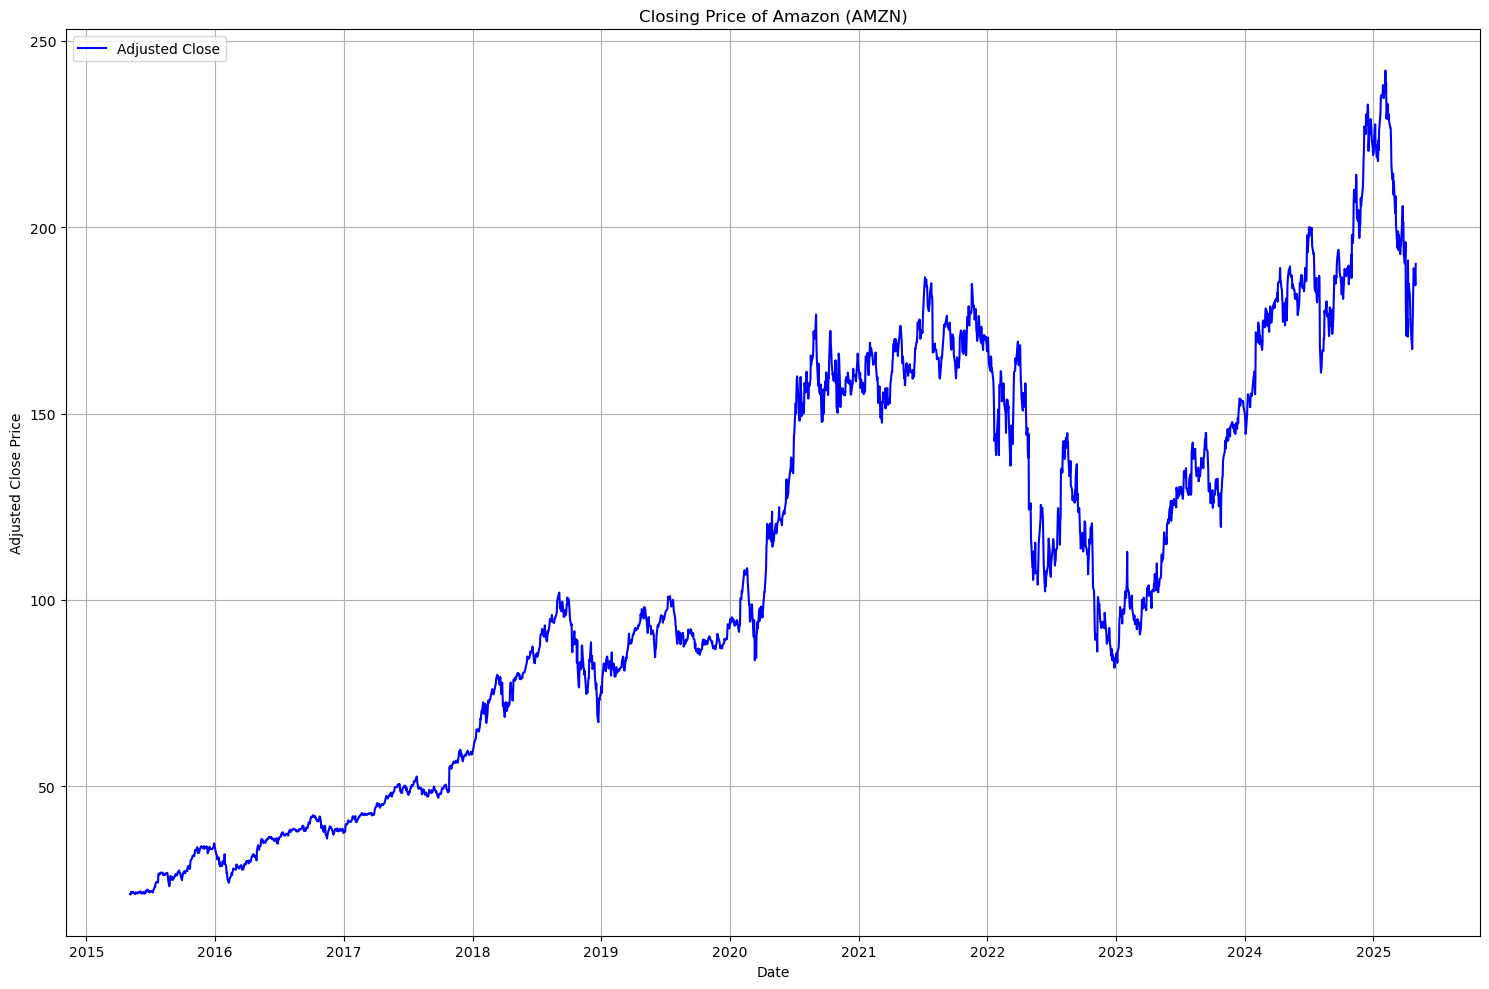

In [96]:

# Time range: past 3 years
# end_date = datetime.now()
# start_date = end_date - timedelta(days=1095)

# Download data for AMZN
# amzn_data = yf.download("AMZN", start=start_date, end=end_date, auto_adjust=False)

# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Plotting the adjusted closing price
plt.plot(amzn_data['Adj Close'], label='Adjusted Close', color='blue')
plt.ylabel('Adjusted Close Price')
plt.xlabel('Date')
plt.title("Closing Price of Amazon (AMZN)")
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()


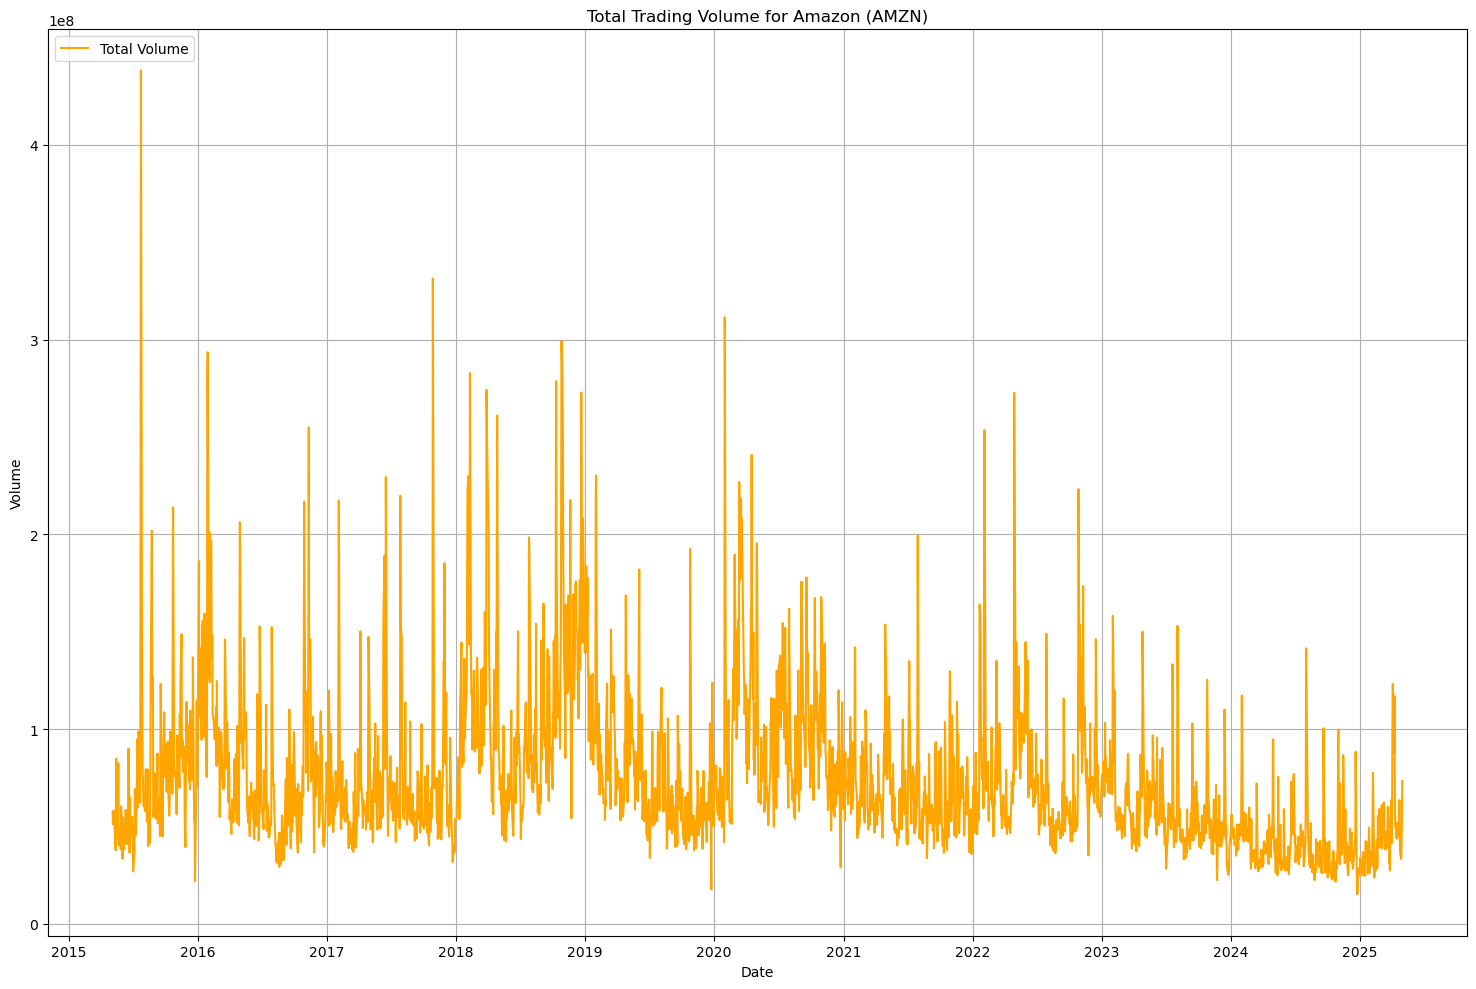

In [97]:
# Now let's plot the total volume of stock being traded each day for Amazon
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Plotting the trading volume for AMZN
plt.plot(amzn_data['Volume'], label='Total Volume', color='orange')
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title("Total Trading Volume for Amazon (AMZN)")
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()

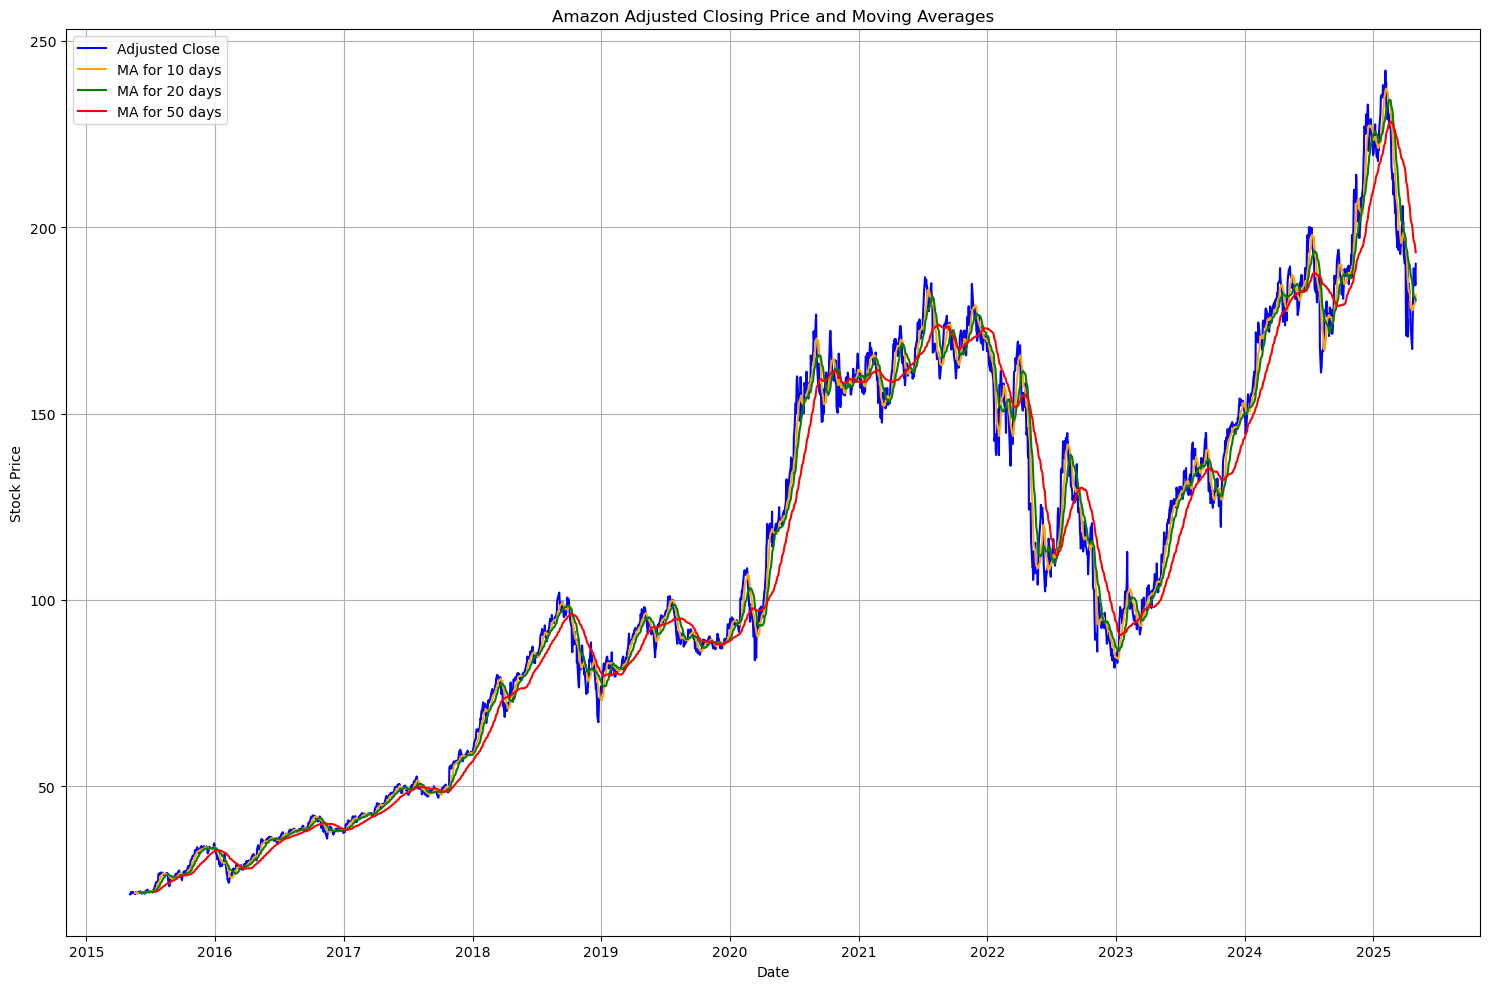

In [98]:
ma_day = [10, 20 ,50]
for ma in ma_day:
    amzn_data[f"MA for {ma} days"] = amzn_data['Adj Close'].rolling(ma).mean()

plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=0.2)

# Plotting adjusted close and moving averages
plt.plot(amzn_data['Adj Close'], label='Adjusted Close', color='blue')
plt.plot(amzn_data['MA for 10 days'], label='MA for 10 days', color='orange')
plt.plot(amzn_data['MA for 20 days'], label='MA for 20 days', color='green')
plt.plot(amzn_data['MA for 50 days'], label='MA for 50 days', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title("Amazon Adjusted Closing Price and Moving Averages")
plt.legend()
plt.tight_layout()
plt.grid()

# Show the plot
plt.show()


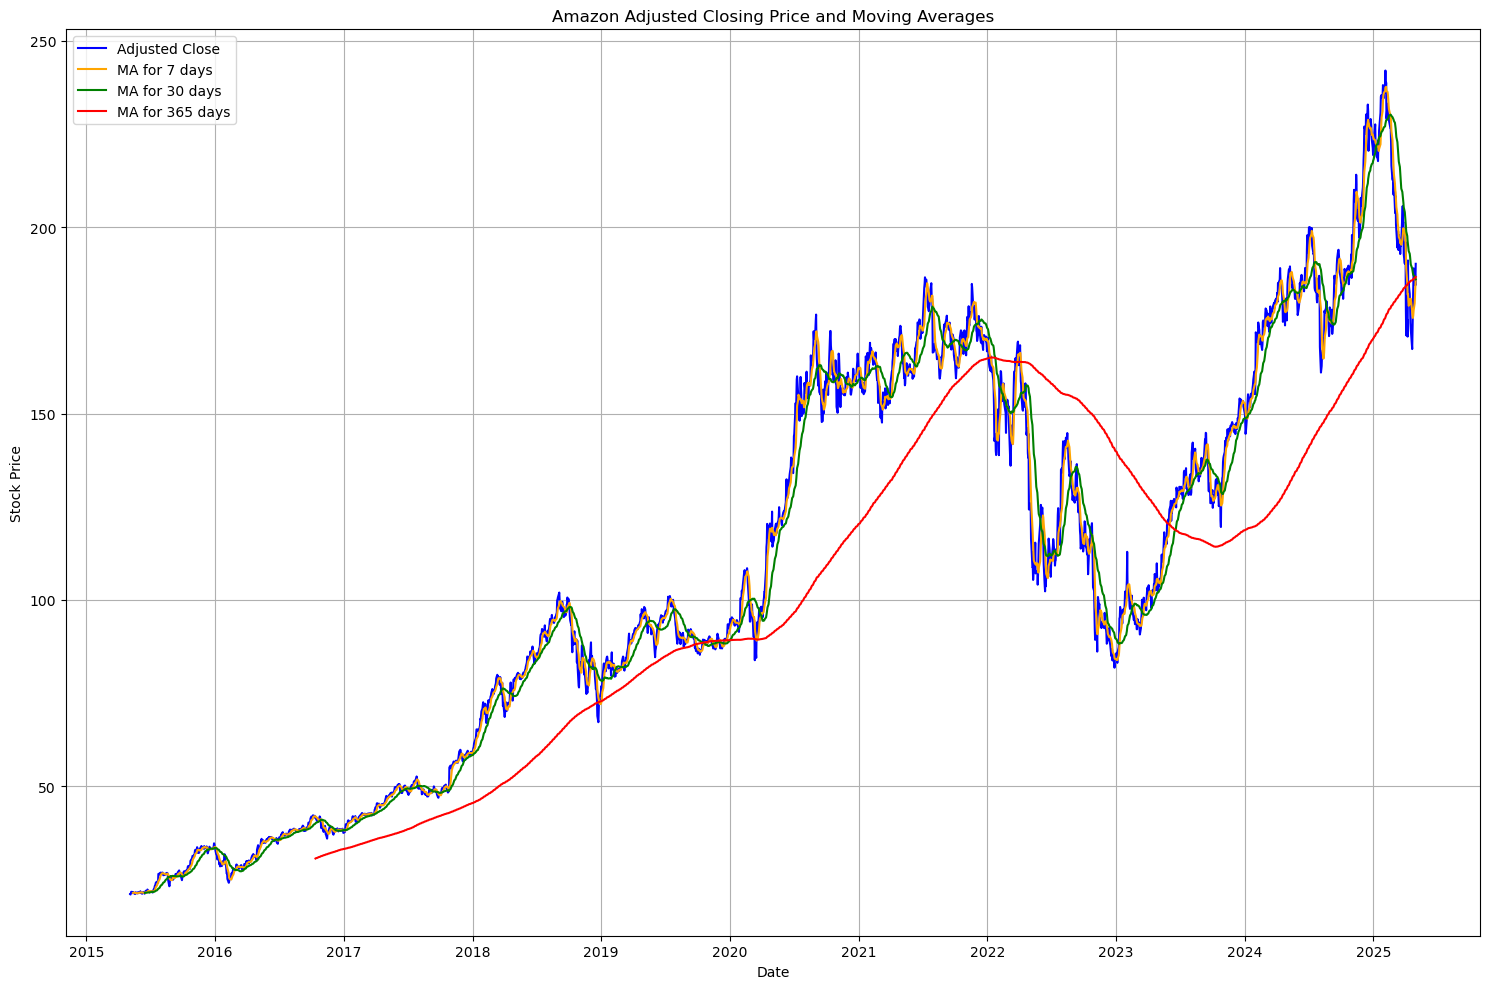

In [99]:

plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=0.2)

# Plotting adjusted close and moving averages
plt.plot(amzn_data['Adj Close'], label='Adjusted Close', color='blue')
plt.plot(amzn_data['MA_7'], label='MA for 7 days', color='orange')
plt.plot(amzn_data['MA_30'], label='MA for 30 days', color='green')
plt.plot(amzn_data['MA_365'], label='MA for 365 days', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title("Amazon Adjusted Closing Price and Moving Averages")
plt.legend()
plt.tight_layout()
plt.grid()

# Show the plot
plt.show()


2514


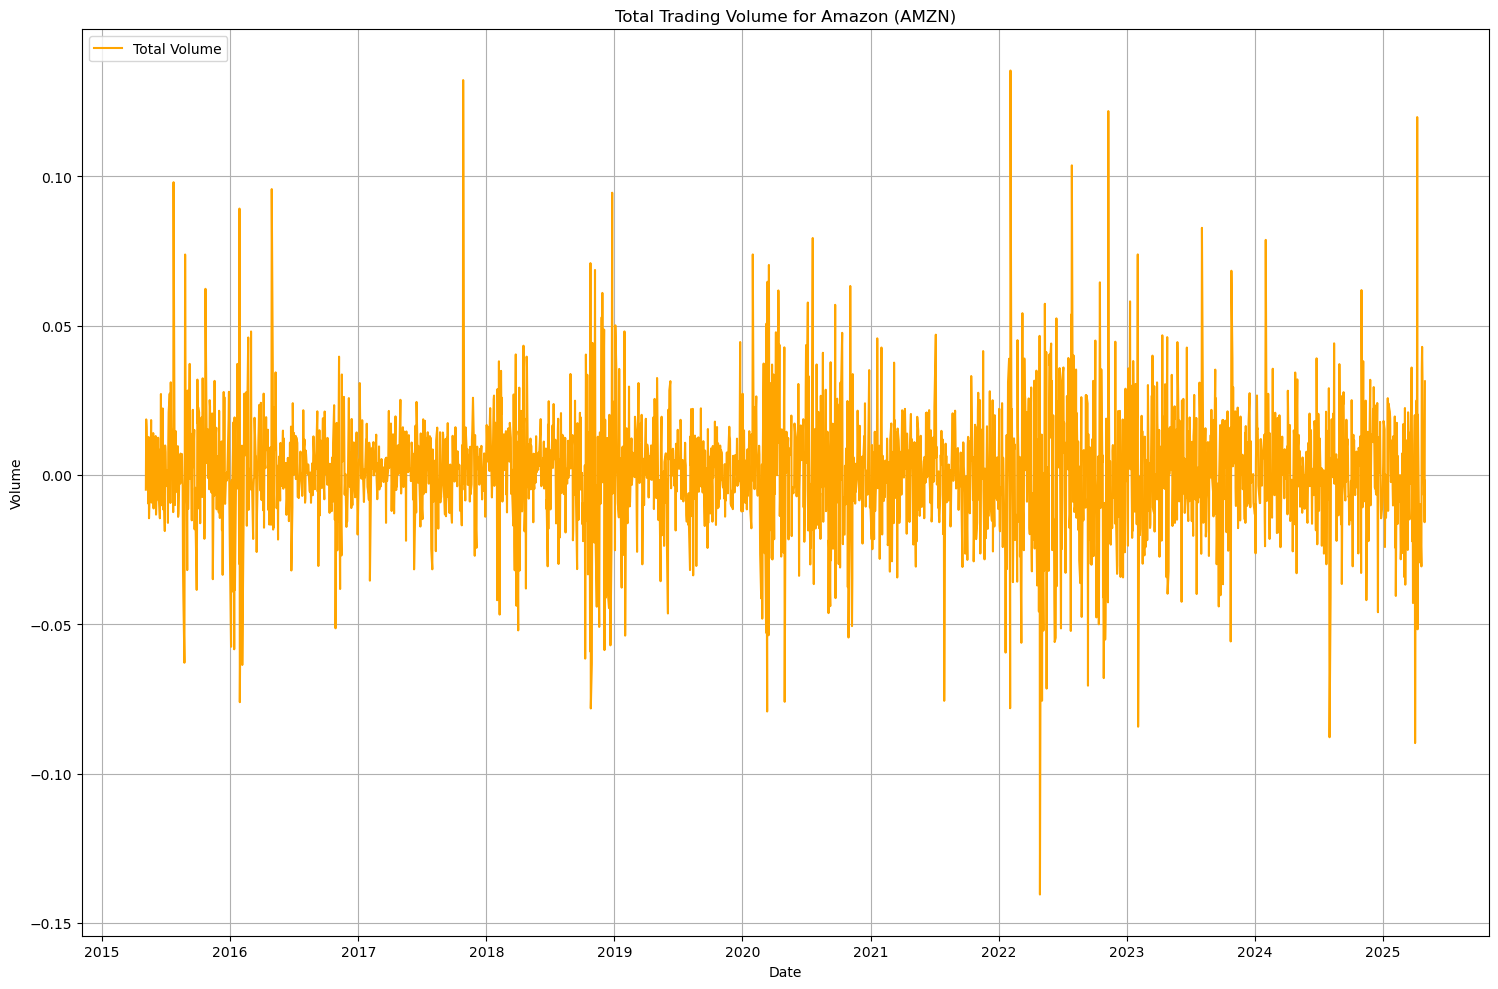

In [100]:
print(len(amzn_data))
# Now let's plot the total volume of stock being traded each day for Amazon
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Plotting the trading volume for AMZN
plt.plot(amzn_data['Pct_Change'], label='Total Volume', color='orange')
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title("Total Trading Volume for Amazon (AMZN)")
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()

In [101]:
# Drop NaN values resulting from calculations

print(len(amzn_data))

# Slice original df to get most recent 3 years. This cuts off NaN values as well.
days = 1095
amzn_data = amzn_data.iloc[-(days+1):-1]

scaler = StandardScaler()
# Selecting features for training
features = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Log_Return', 'Pct_Change', 'MA_7', 'MA_30', 'MA_365', 'Volatility_7d', 'PE_Ratio']
data = amzn_data[features]

amzn_data[features] = scaler.fit_transform(amzn_data[features])

2514


In [102]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [103]:
X = []
y = []
print(len(amzn_data))
# print(len(amzn_data))
time_steps = 30  # Lookback period
for i in range(time_steps, len(amzn_data)):
    # the line of code below adds all the features from the lookback start to the day before the current
    X.append(amzn_data[features].iloc[i-time_steps:i].values)  # Use NumPy slicing instead of iloc
    # the line below adds only the 'closing price' feature to y on the currnet day that it's trying to predict
    y.append(amzn_data['Close'].iloc[i])

X, y = np.array(X), np.array(y)
print(X.shape)
# Train-test split for LSTM
# from sklearn.model_selection import train_test_split
# the 80% to 20% training-test split ensures that the predicted closing prices are not cheating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_val.shape)

1095
(1065, 30, 13)
(681, 30, 13)
(171, 30, 13)


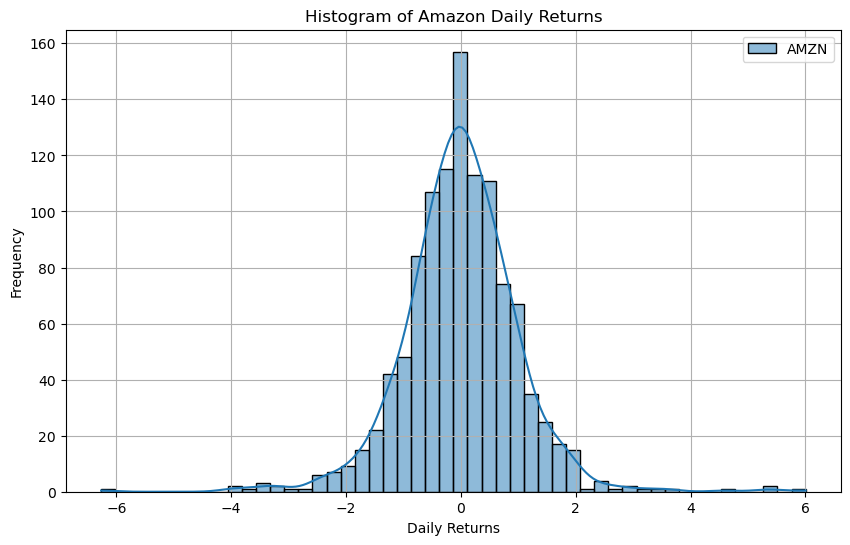

In [104]:

plt.figure(figsize=(10, 6))
sns.histplot(amzn_data['Pct_Change'].dropna(), bins=50, kde=True, color='seagreen')
plt.title('Histogram of Amazon Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.grid()
plt.show()


MultiIndex([(     'Adj Close', 'AMZN'),
            (         'Close', 'AMZN'),
            (          'High', 'AMZN'),
            (           'Low', 'AMZN'),
            (          'Open', 'AMZN'),
            (        'Volume', 'AMZN'),
            (      'PE_Ratio', 'AMZN'),
            (    'Log_Return', 'AMZN'),
            ( 'Volatility_7d', 'AMZN'),
            (          'MA_7', 'AMZN'),
            (         'MA_30', 'AMZN'),
            (        'MA_365', 'AMZN'),
            (    'Pct_Change', 'AMZN'),
            ('MA for 10 days',     ''),
            ('MA for 20 days',     ''),
            ('MA for 50 days',     '')],
           )
           Adj Close     Close      High       Low      Open    Volume  \
                AMZN      AMZN      AMZN      AMZN      AMZN      AMZN   
Date                                                                     
2020-12-18  0.166172  0.166172  0.179258  0.180946  0.226036  2.178184   
2020-12-21  0.172657  0.172657  0.147245  0.172884

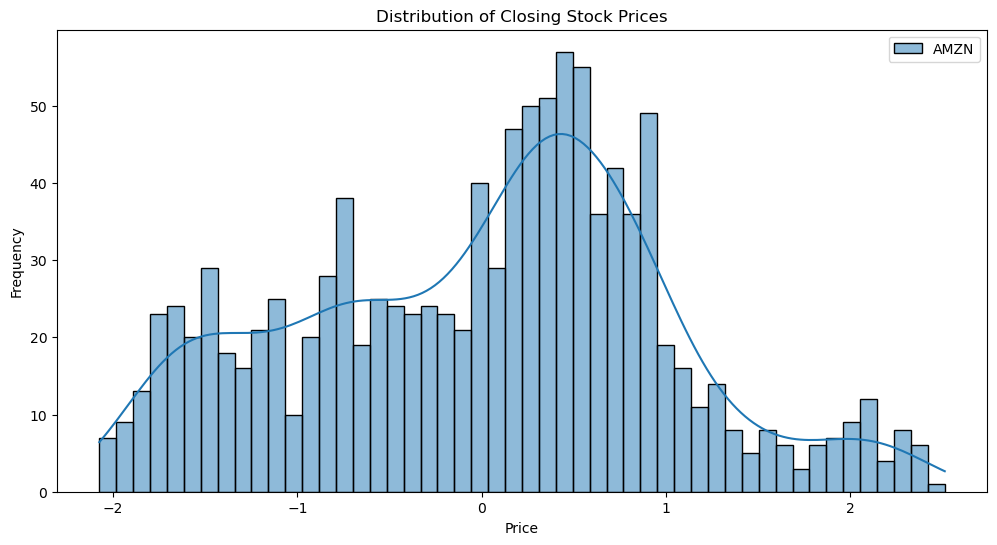

In [105]:

# Convert 'Close' column to numeric
# amzn_data['Close'] = pd.to_numeric(amzn_data['Close'], errors='coerce')
assert isinstance(amzn_data, pd.DataFrame)

print(amzn_data.columns)
# Drop rows with missing 'Close' values
# amzn_data = amzn_data.dropna(subset=['Close'])

print(amzn_data.head())
print(amzn_data.tail())
# Visualize the distribution of 'Close' prices
plt.figure(figsize=(12, 6))
sns.histplot(amzn_data['Close'], bins=50, kde=True, color='blue')
plt.title('Distribution of Closing Stock Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# # Visualize the 'Sentiment_Score'
# plt.figure(figsize=(12, 6))
# sns.histplot(amzn_data['Sentiment'], bins=50, kde=True, color='green')
# plt.title('Distribution of Sentiment Scores')
# plt.xlabel('Sentiment Score')
# plt.ylabel('Frequency')
# plt.show()


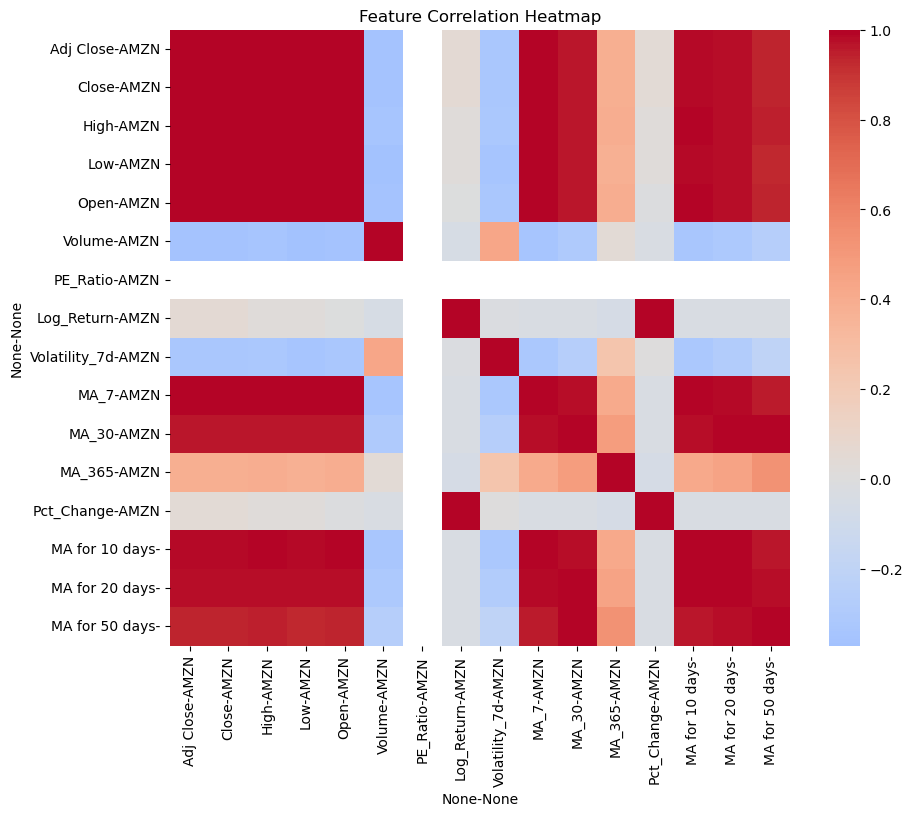

In [106]:
# Observe correlation heatmap (before PCA)

plt.figure(figsize=(10, 8))
sns.heatmap(amzn_data.corr(), annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

In [107]:
# Explore data patterns/structures using PCA (dimensionality reduction)

# Perform PCA on origina data
pca = PCA(n_components=0.95)
amzn_data_pca = pca.fit_transform(amzn_data)

# Turn your MultiIndex into flat names
amzn_data.columns = [col[0] if isinstance(col, tuple) else col for col in amzn_data.columns]

# Calculate component loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=amzn_data.columns)

Variance explained by components: [0.98316104]
Number of principal components: 1


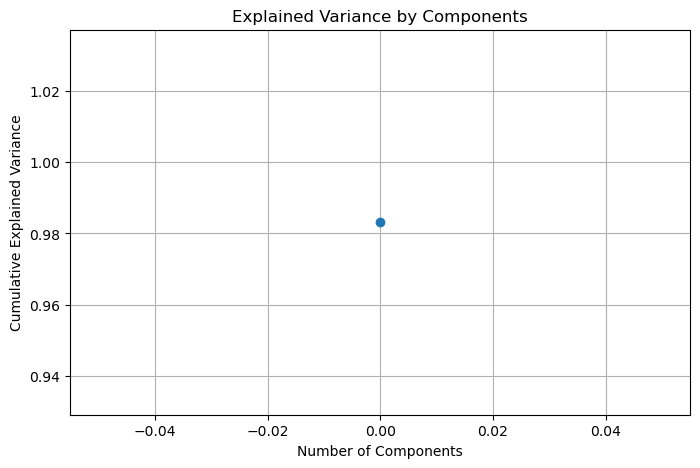

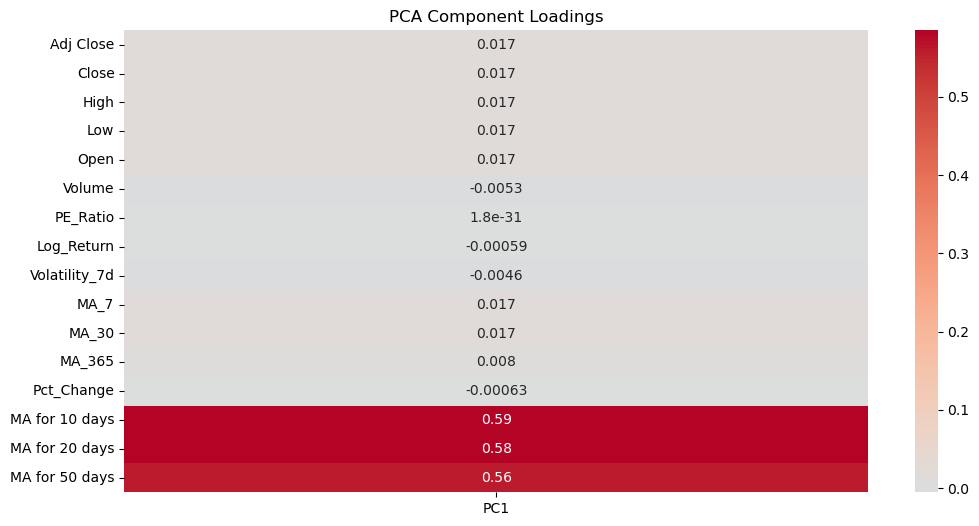

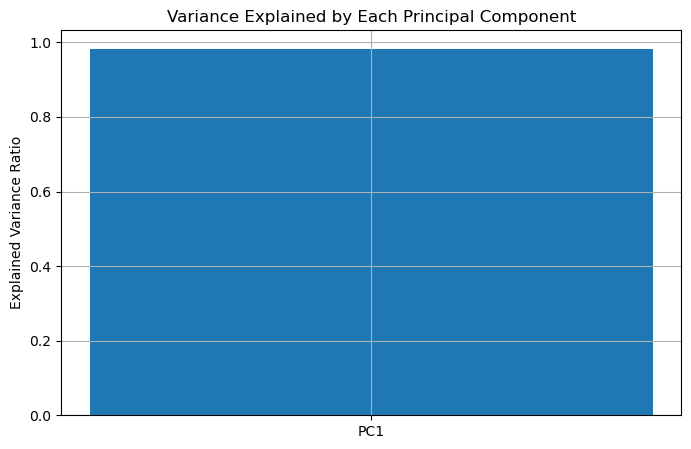

In [108]:
# Amount of variance explained by component(s)
print("Variance explained by components:", pca.explained_variance_ratio_)
# Observe: 98.3% of the variance in our data is explained by 1 principal component

# Number of principal components
print("Number of principal components:", pca.n_components_)

# Explained Variance Ratio Plot
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

# Plot a heatmap of the loadings
plt.figure(figsize=(12, 6))
sns.heatmap(loadings, cmap='coolwarm', center=0, annot=True)
plt.title('PCA Component Loadings')
plt.show()

# Bar Plot of Individual Explained Variance per Component
plt.figure(figsize=(8, 5))
plt.bar(x=[f'PC{i+1}' for i in range(pca.n_components_)], height=pca.explained_variance_ratio_)
plt.ylabel('Explained Variance Ratio')
plt.title('Variance Explained by Each Principal Component')
plt.grid(True)
plt.show()

In [109]:
# 1
# Tuning the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.05)),
    # Dropout(0.3),
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.1)),
    Dense(50),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


# 2
# Tuning the LSTM model
model_reg2 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01)),
    # Dropout(0.3),
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)),
    Dense(50),
    Dense(1)
])

# Compile the model
model_reg2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model_reg2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


# 3
# Tuning the LSTM model
model_reg3 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.5)),
    # Dropout(0.3),
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.5)),
    Dense(50),
    Dense(1)
])

# Compile the model
model_reg3.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model_reg3.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

# 4
# Tuning the LSTM model
model_reg4 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.25)),
    # Dropout(0.3),
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.25)),
    Dense(50),
    Dense(1)
])

# Compile the model
model_reg4.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model_reg4.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

# 5
# Tuning the LSTM model
model_reg5 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.15)),
    # Dropout(0.3),
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.15)),
    Dense(50),
    Dense(1)
])

# Compile the model
model_reg5.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model_reg5.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

# 6
# Tuning the LSTM model
model_reg6 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.001)),
    # Dropout(0.3),
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.001)),
    Dense(50),
    Dense(1)
])

# Compile the model
model_reg6.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model_reg6.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))






Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 11.5869 - val_loss: 9.3376
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.8493 - val_loss: 7.3656
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.9588 - val_loss: 5.7500
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.4189 - val_loss: 4.4591
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.1956 - val_loss: 3.4295
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.2288 - val_loss: 2.6275
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.4707 - val_loss: 2.0058
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8854 - val_loss: 1.5275
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.4347 - val_loss: 1.1584
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0902 - val_loss: 0.8789
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8293 - val_loss: 0.6677
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6322 - val_

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


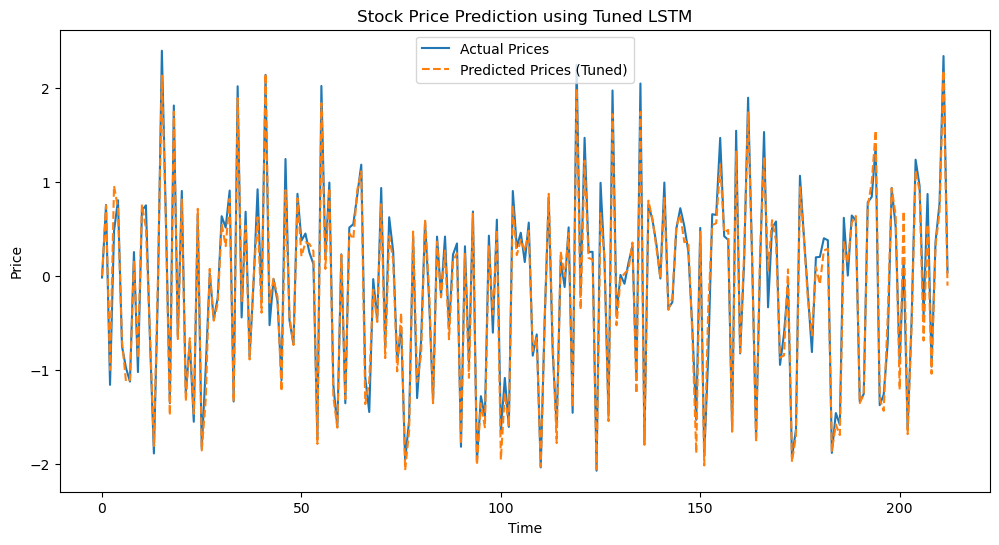

In [110]:
# use the trained LSTM to predict the closing prices for the p
lstm_predictions_model = model.predict(X_test)

# Plot the results for the tuned LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(lstm_predictions_model, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Tuned LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()



In [111]:
# Calculate metrics
mse = mean_squared_error(y_test, lstm_predictions_model)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, lstm_predictions_model)
r2 = r2_score(y_test, lstm_predictions_model)

#train metrics
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

#val metrics
y_val_pred = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse)
print("R-squared (R²):", train_r2)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse)
print("R-squared (R²):", val_r2)

##########
predicted_model_reg2 = model_reg2.predict(X_test)
# Calculate metrics
mse = mean_squared_error(y_test, predicted_model_reg2)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicted_model_reg2)
r2 = r2_score(y_test, predicted_model_reg2)

#train metrics
y_train_pred = model_reg2.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

#val metrics
y_val_pred = model_reg2.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse)
print("R-squared (R²):", train_r2)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse)
print("R-squared (R²):", val_r2)

###########
predicted_model_reg3 = model_reg3.predict(X_test)
# Calculate metrics
mse = mean_squared_error(y_test, predicted_model_reg3)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicted_model_reg3)
r2 = r2_score(y_test, predicted_model_reg3)

#train metrics
y_train_pred = model_reg3.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

#val metrics
y_val_pred = model_reg3.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse)
print("R-squared (R²):", train_r2)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse)
print("R-squared (R²):", val_r2)


###########
predicted_model_reg4 = model_reg4.predict(X_test)
# Calculate metrics
mse = mean_squared_error(y_test, predicted_model_reg4)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicted_model_reg4)
r2 = r2_score(y_test, predicted_model_reg4)

#train metrics
y_train_pred = model_reg4.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

#val metrics
y_val_pred = model_reg4.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse)
print("R-squared (R²):", train_r2)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse)
print("R-squared (R²):", val_r2)



###########
predicted_model_reg5 = model_reg5.predict(X_test)
# Calculate metrics
mse = mean_squared_error(y_test, predicted_model_reg5)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicted_model_reg5)
r2 = r2_score(y_test, predicted_model_reg5)

#train metrics
y_train_pred = model_reg5.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

#val metrics
y_val_pred = model_reg5.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse)
print("R-squared (R²):", train_r2)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse)
print("R-squared (R²):", val_r2)


###########
predicted_model_reg6 = model_reg6.predict(X_test)
# Calculate metrics
mse = mean_squared_error(y_test, predicted_model_reg6)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicted_model_reg6)
r2 = r2_score(y_test, predicted_model_reg6)

#train metrics
y_train_pred = model_reg6.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

#val metrics
y_val_pred = model_reg6.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse)
print("R-squared (R²):", train_r2)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse)
print("R-squared (R²):", val_r2)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Mean Squared Error (MSE): 0.021893702604749966
Root Mean Squared Error (RMSE): 0.14796520741292518
Mean Absolute Error (MAE): 0.11328179596151325
R-squared (R²): 0.9789853222218089
Training:

Mean Squared Error (MSE): 0.018306904116131912
R-squared (R²): 0.9818760331404549
Validation:

Mean Squared Error (MSE): 0.013551420867380478
R-squared (R²): 0.9870187739694538
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Mean Squared Error (MSE): 0.013480146983641
R-squared (R²): 0.9870610764027455
Training:

Mean Squared Error (MSE): 0.010450227104322241
R-squared (R²): 0.9896541999394338
Validation:

Mean Squared Error (MSE): 0.007375491199114344
R-squared (R²): 0.9929348428272589
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Mean Squared Error (MSE): 0.03879401915476325
R-squared (R²)

In [112]:
# Tuning the LSTM model
model2 = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

###########
# Tuning the LSTM model
model2_reg2 = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
model2_reg2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model2_reg2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

###########
# Tuning the LSTM model
model2_reg3 = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.01),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
model2_reg3.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model2_reg3.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))



###########
# Tuning the LSTM model
model2_reg4 = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.001),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
model2_reg4.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model2_reg4.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))



###########
# Tuning the LSTM model
model2_reg5 = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.9),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
model2_reg5.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model2_reg5.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))



###########
# Tuning the LSTM model
model2_reg6 = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.7),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
model2_reg6.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model2_reg6.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))



Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7215 - val_loss: 0.0678
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0948 - val_loss: 0.0506
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0664 - val_loss: 0.0189
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0523 - val_loss: 0.0187
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0457 - val_loss: 0.0124
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0353 - val_loss: 0.0123
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0345 - val_loss: 0.0142
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0297 - val_loss: 0.0110
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0264 - val_loss: 0.0090
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0251 - val_loss: 0.0120
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0283 - val_loss: 0.0112
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0286 - val_loss: 0

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


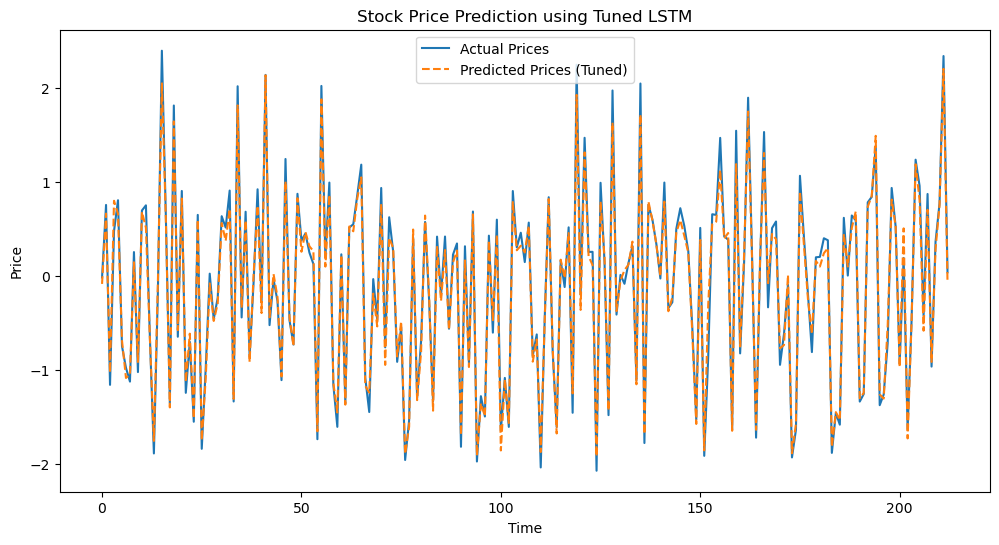

In [113]:
# use the trained LSTM to predict the closing prices for the p
lstm_predictions_model2 = model2.predict(X_test)

# lstm_predictions_model2 = lstm_predictions_model2[:, -1, 0]
# Plot the results for the tuned LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(lstm_predictions_model2, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Tuned LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [114]:
# Calculate metrics
mse2 = mean_squared_error(y_test, lstm_predictions_model2)
rmse2 = np.sqrt(mse2)
mae2 = mean_absolute_error(y_test, lstm_predictions_model2)
r2_2 = r2_score(y_test, lstm_predictions_model2)

#train metrics
y_train_pred2 = model2.predict(X_train)
train_mse2 = mean_squared_error(y_train, y_train_pred2)
train_r2_2 = r2_score(y_train, y_train_pred2)

#val metrics
y_val_pred2 = model2.predict(X_val)
val_mse2 = mean_squared_error(y_val, y_val_pred2)
val_r2_2 = r2_score(y_val, y_val_pred2)

# Output the results
print("Mean Squared Error (MSE):", mse2)
print("R-squared (R²):", r2_2)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse2)
print("R-squared (R²):", train_r2_2)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse2)
print("R-squared (R²):", val_r2_2)


#########
predicted_model2_reg2 = model2_reg2.predict(X_test)
# Calculate metrics
mse2 = mean_squared_error(y_test, predicted_model2_reg2)
rmse2 = np.sqrt(mse2)
mae2 = mean_absolute_error(y_test, predicted_model2_reg2)
r2_2 = r2_score(y_test, predicted_model2_reg2)

#train metrics
y_train_pred2 = model2_reg2.predict(X_train)
train_mse2 = mean_squared_error(y_train, y_train_pred2)
train_r2_2 = r2_score(y_train, y_train_pred2)

#val metrics
y_val_pred2 = model2_reg2.predict(X_val)
val_mse2 = mean_squared_error(y_val, y_val_pred2)
val_r2_2 = r2_score(y_val, y_val_pred2)

# Output the results
print("Mean Squared Error (MSE):", mse2)
print("R-squared (R²):", r2_2)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse2)
print("R-squared (R²):", train_r2_2)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse2)
print("R-squared (R²):", val_r2_2)

#########
predicted_model2_reg3 = model2_reg3.predict(X_test)
# Calculate metrics
mse2 = mean_squared_error(y_test, predicted_model2_reg3)
rmse2 = np.sqrt(mse2)
mae2 = mean_absolute_error(y_test, predicted_model2_reg3)
r2_2 = r2_score(y_test, predicted_model2_reg3)

#train metrics
y_train_pred2 = model2_reg3.predict(X_train)
train_mse2 = mean_squared_error(y_train, y_train_pred2)
train_r2_2 = r2_score(y_train, y_train_pred2)

#val metrics
y_val_pred2 = model2_reg3.predict(X_val)
val_mse2 = mean_squared_error(y_val, y_val_pred2)
val_r2_2 = r2_score(y_val, y_val_pred2)

# Output the results
print("Mean Squared Error (MSE):", mse2)
print("R-squared (R²):", r2_2)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse2)
print("R-squared (R²):", train_r2_2)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse2)
print("R-squared (R²):", val_r2_2)


#########
predicted_model2_reg4 = model2_reg4.predict(X_test)
# Calculate metrics
mse2 = mean_squared_error(y_test, predicted_model2_reg4)
rmse2 = np.sqrt(mse2)
mae2 = mean_absolute_error(y_test, predicted_model2_reg4)
r2_2 = r2_score(y_test, predicted_model2_reg4)

#train metrics
y_train_pred2 = model2_reg4.predict(X_train)
train_mse2 = mean_squared_error(y_train, y_train_pred2)
train_r2_2 = r2_score(y_train, y_train_pred2)

#val metrics
y_val_pred2 = model2_reg4.predict(X_val)
val_mse2 = mean_squared_error(y_val, y_val_pred2)
val_r2_2 = r2_score(y_val, y_val_pred2)

# Output the results
print("Mean Squared Error (MSE):", mse2)
print("R-squared (R²):", r2_2)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse2)
print("R-squared (R²):", train_r2_2)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse2)
print("R-squared (R²):", val_r2_2)


#########
predicted_model2_reg5 = model2_reg5.predict(X_test)
# Calculate metrics
mse2 = mean_squared_error(y_test, predicted_model2_reg5)
rmse2 = np.sqrt(mse2)
mae2 = mean_absolute_error(y_test, predicted_model2_reg5)
r2_2 = r2_score(y_test, predicted_model2_reg5)

#train metrics
y_train_pred2 = model2_reg5.predict(X_train)
train_mse2 = mean_squared_error(y_train, y_train_pred2)
train_r2_2 = r2_score(y_train, y_train_pred2)

#val metrics
y_val_pred2 = model2_reg5.predict(X_val)
val_mse2 = mean_squared_error(y_val, y_val_pred2)
val_r2_2 = r2_score(y_val, y_val_pred2)

# Output the results
print("Mean Squared Error (MSE):", mse2)
print("R-squared (R²):", r2_2)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse2)
print("R-squared (R²):", train_r2_2)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse2)
print("R-squared (R²):", val_r2_2)


#########
predicted_model2_reg6 = model2_reg6.predict(X_test)
# Calculate metrics
mse2 = mean_squared_error(y_test, predicted_model2_reg6)
rmse2 = np.sqrt(mse2)
mae2 = mean_absolute_error(y_test, predicted_model2_reg6)
r2_2 = r2_score(y_test, predicted_model2_reg6)

#train metrics
y_train_pred2 = model2_reg6.predict(X_train)
train_mse2 = mean_squared_error(y_train, y_train_pred2)
train_r2_2 = r2_score(y_train, y_train_pred2)

#val metrics
y_val_pred2 = model2_reg6.predict(X_val)
val_mse2 = mean_squared_error(y_val, y_val_pred2)
val_r2_2 = r2_score(y_val, y_val_pred2)

# Output the results
print("Mean Squared Error (MSE):", mse2)
print("R-squared (R²):", r2_2)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse2)
print("R-squared (R²):", train_r2_2)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse2)
print("R-squared (R²):", val_r2_2)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error (MSE): 0.01608099934512242
R-squared (R²): 0.9845646473924546
Training:

Mean Squared Error (MSE): 0.014305484599281224
R-squared (R²): 0.9858374672668637
Validation:

Mean Squared Error (MSE): 0.012562047829339187
R-squared (R²): 0.9879665177640737
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error (MSE): 0.012531763146647185
R-squared (R²): 0.9879713829463334
Training:

Mean Squared Error (MSE): 0.007731525453506477
R-squared (R²): 0.9923457341446605
Validation:

Mean Squared Error (MSE): 0.007006093621402063
R-squared (R²): 0.9932886974893159
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error (MSE): 0.013429312475714324
R-squared (R²): 0.9871098699222053
Training:

Mean Squared Error (MSE): 0.006317319555001566
R-squared (R²): 

In [115]:
# Tuning the LSTM model
model3 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.23),
    LSTM(80, return_sequences=False),
    Dropout(0.23),
    Dense(50),
    Dense(1)
])

# Compile the model
model3.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model3.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

#############
# Tuning the LSTM model
model3_reg2 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(80, return_sequences=False),
    Dropout(0.3),
    Dense(50),
    Dense(1)
])

# Compile the model
model3_reg2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model3_reg2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


#############
# Tuning the LSTM model
model3_reg3 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    LSTM(64, return_sequences=True),
    Dropout(0.1),
    LSTM(80, return_sequences=False),
    Dropout(0.1),
    Dense(50),
    Dense(1)
])

# Compile the model
model3_reg3.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model3_reg3.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


#############
# Tuning the LSTM model
model3_reg4 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.01),
    LSTM(64, return_sequences=True),
    Dropout(0.01),
    LSTM(80, return_sequences=False),
    Dropout(0.01),
    Dense(50),
    Dense(1)
])

# Compile the model
model3_reg4.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model3_reg4.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


#############
# Tuning the LSTM model
model3_reg5 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.5),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(80, return_sequences=False),
    Dropout(0.5),
    Dense(50),
    Dense(1)
])

# Compile the model
model3_reg5.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model3_reg5.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


#############
# Tuning the LSTM model
model3_reg6 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.8),
    LSTM(64, return_sequences=True),
    Dropout(0.8),
    LSTM(80, return_sequences=False),
    Dropout(0.8),
    Dense(50),
    Dense(1)
])

# Compile the model
model3_reg6.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model3_reg6.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.5823 - val_loss: 0.1148
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1188 - val_loss: 0.0400
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0760 - val_loss: 0.0389
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0545 - val_loss: 0.0259
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0389 - val_loss: 0.0190
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0437 - val_loss: 0.0217
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0339 - val_loss: 0.0168
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0348 - val_loss: 0.0187
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0304 - val_loss: 0.0144
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0330 - val_loss: 0.0165
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0326 - val_loss: 0.0120
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0271 - val_l

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


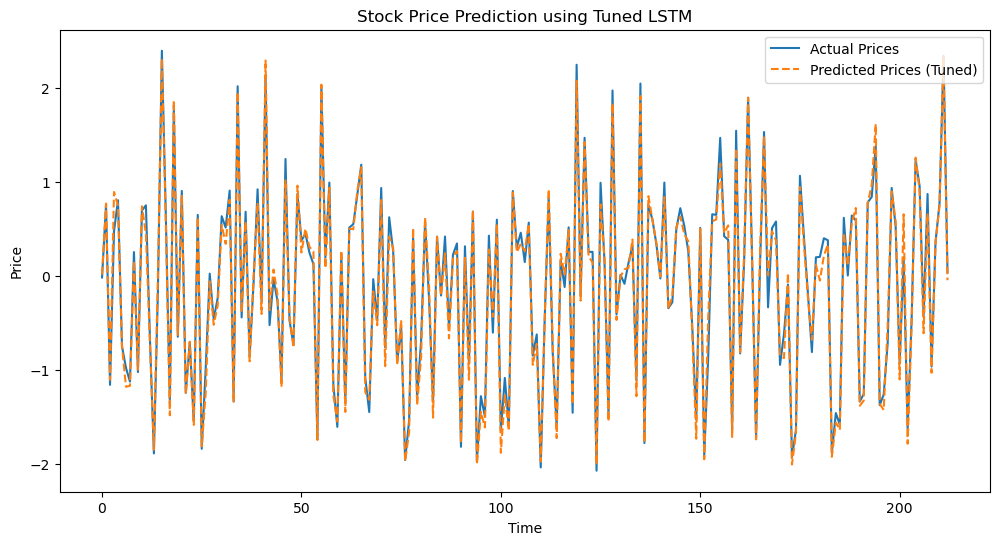

In [116]:
# use the trained LSTM to predict the closing prices for the p
lstm_predictions_model3 = model3.predict(X_test)
predicted_model3_reg2 = model3_reg2.predict(X_test)
predicted_model3_reg3 = model3_reg3.predict(X_test)
predicted_model3_reg4 = model3_reg4.predict(X_test)
predicted_model3_reg5 = model3_reg5.predict(X_test)
predicted_model3_reg6 = model3_reg6.predict(X_test)





# lstm_predictions_model3 = lstm_predictions_model3[:, -1, 0]
# Plot the results for the tuned LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(lstm_predictions_model3, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Tuned LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [117]:
# Calculate metrics
mse3 = mean_squared_error(y_test, lstm_predictions_model3)
rmse3 = np.sqrt(mse3)
mae3 = mean_absolute_error(y_test, lstm_predictions_model3)
r2_3 = r2_score(y_test, lstm_predictions_model3)

#train metrics
y_train_pred3 = model3.predict(X_train)
train_mse3 = mean_squared_error(y_train, y_train_pred3)
train_r2_3 = r2_score(y_train, y_train_pred3)

#val metrics
y_val_pred3 = model3.predict(X_val)
val_mse3 = mean_squared_error(y_val, y_val_pred3)
val_r2_3 = r2_score(y_val, y_val_pred3)

# Output the results
print("Mean Squared Error (MSE):", mse3)
print("R-squared (R²):", r2_3)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse3)
print("R-squared (R²):", train_r2_3)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse3)
print("R-squared (R²):", val_r2_3)


############
# Calculate metrics
mse3 = mean_squared_error(y_test, predicted_model_reg2)
rmse3 = np.sqrt(mse3)
mae3 = mean_absolute_error(y_test, predicted_model_reg2)
r2_3 = r2_score(y_test, predicted_model_reg2)

#train metrics
y_train_pred3 = model3_reg2.predict(X_train)
train_mse3 = mean_squared_error(y_train, y_train_pred3)
train_r2_3 = r2_score(y_train, y_train_pred3)

#val metrics
y_val_pred3 = model3_reg2.predict(X_val)
val_mse3 = mean_squared_error(y_val, y_val_pred3)
val_r2_3 = r2_score(y_val, y_val_pred3)

# Output the results
print("Mean Squared Error (MSE):", mse3)
print("R-squared (R²):", r2_3)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse3)
print("R-squared (R²):", train_r2_3)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse3)
print("R-squared (R²):", val_r2_3)


############
# Calculate metrics
mse3 = mean_squared_error(y_test, predicted_model_reg3)
rmse3 = np.sqrt(mse3)
mae3 = mean_absolute_error(y_test, predicted_model_reg3)
r2_3 = r2_score(y_test, predicted_model_reg3)

#train metrics
y_train_pred3 = model3_reg3.predict(X_train)
train_mse3 = mean_squared_error(y_train, y_train_pred3)
train_r2_3 = r2_score(y_train, y_train_pred3)

#val metrics
y_val_pred3 = model3_reg3.predict(X_val)
val_mse3 = mean_squared_error(y_val, y_val_pred3)
val_r2_3 = r2_score(y_val, y_val_pred3)

# Output the results
print("Mean Squared Error (MSE):", mse3)
print("R-squared (R²):", r2_3)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse3)
print("R-squared (R²):", train_r2_3)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse3)
print("R-squared (R²):", val_r2_3)

############
# Calculate metrics
mse3 = mean_squared_error(y_test, predicted_model_reg4)
rmse3 = np.sqrt(mse3)
mae3 = mean_absolute_error(y_test, predicted_model_reg4)
r2_3 = r2_score(y_test, predicted_model_reg4)

#train metrics
y_train_pred3 = model3_reg4.predict(X_train)
train_mse3 = mean_squared_error(y_train, y_train_pred)
train_r2_3 = r2_score(y_train, y_train_pred3)

#val metrics
y_val_pred3 = model3_reg4.predict(X_val)
val_mse3 = mean_squared_error(y_val, y_val_pred3)
val_r2_3 = r2_score(y_val, y_val_pred3)

# Output the results
print("Mean Squared Error (MSE):", mse3)
print("R-squared (R²):", r2_3)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse3)
print("R-squared (R²):", train_r2_3)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse3)
print("R-squared (R²):", val_r2_3)

############
# Calculate metrics
mse3 = mean_squared_error(y_test, predicted_model_reg5)
rmse3 = np.sqrt(mse3)
mae3 = mean_absolute_error(y_test, predicted_model_reg5)
r2_3 = r2_score(y_test, predicted_model_reg5)

#train metrics
y_train_pred3 = model3_reg5.predict(X_train)
train_mse3 = mean_squared_error(y_train, y_train_pred3)
train_r2_3 = r2_score(y_train, y_train_pred3)

#val metrics
y_val_pred3 = model3_reg5.predict(X_val)
val_mse3 = mean_squared_error(y_val, y_val_pred3)
val_r2_3 = r2_score(y_val, y_val_pred3)

# Output the results
print("Mean Squared Error (MSE):", mse3)
print("R-squared (R²):", r2_3)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse3)
print("R-squared (R²):", train_r2_3)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse3)
print("R-squared (R²):", val_r2_3)

############
# Calculate metrics
mse3 = mean_squared_error(y_test, predicted_model_reg6)
rmse3 = np.sqrt(mse3)
mae3 = mean_absolute_error(y_test, predicted_model_reg6)
r2_3 = r2_score(y_test, predicted_model_reg6)

#train metrics
y_train_pred3 = model3_reg6.predict(X_train)
train_mse3 = mean_squared_error(y_train, y_train_pred3)
train_r2_3 = r2_score(y_train, y_train_pred3)

#val metrics
y_val_pred3 = model3_reg6.predict(X_val)
val_mse3 = mean_squared_error(y_val, y_val_pred3)
val_r2_3 = r2_score(y_val, y_val_pred3)

# Output the results
print("Mean Squared Error (MSE):", mse3)
print("R-squared (R²):", r2_3)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse3)
print("R-squared (R²):", train_r2_3)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse3)
print("R-squared (R²):", val_r2_3)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Mean Squared Error (MSE): 0.014818134202527436
R-squared (R²): 0.9857768089225553
Training:

Mean Squared Error (MSE): 0.010457669267466706
R-squared (R²): 0.9896468321443475
Validation:

Mean Squared Error (MSE): 0.008420562825106647
R-squared (R²): 0.991933744040063
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Mean Squared Error (MSE): 0.013480146983641
R-squared (R²): 0.9870610764027455
Training:

Mean Squared Error (MSE): 0.01055461929630938
R-squared (R²): 0.9895508509178861
Validation:

Mean Squared Error (MSE): 0.009163480800798358
R-squared (R²): 0.9912220853690653
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Mean Squared Error (MSE): 0.03879401915476325
R-squared (R²): 0.9627635477207289
Training:

Mean Squared Error (MSE): 0.012423716501843528
R-squared (R²): 0.9877004312294737
Validation:

Mean Squared Error (MSE): 0.012639098583123546


In [118]:
# Tuning the LSTM model
model4 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.23),
    Dense(50),
    Dense(1)
])

# Compile the model
model4.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model4.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))
# use the trained LSTM to predict the closing prices for the p
lstm_predictions_model4 = model4.predict(X_test)

Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.4215 - val_loss: 0.0598
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0941 - val_loss: 0.0419
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0515 - val_loss: 0.0302
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0517 - val_loss: 0.0191
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0326 - val_loss: 0.0121
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0283 - val_loss: 0.0108
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0266 - val_loss: 0.0094
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0278 - val_loss: 0.0131
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0229 - val_loss: 0.0091
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0256 - val_loss: 0.0086
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0257 - val_loss: 0.0109
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0233 - val_l

In [119]:
# Calculate metrics
mse4 = mean_squared_error(y_test, lstm_predictions_model4)
rmse4 = np.sqrt(mse4)
mae4 = mean_absolute_error(y_test, lstm_predictions_model4)
r2_4 = r2_score(y_test, lstm_predictions_model4)

#train metrics
y_train_pred4 = model4.predict(X_train)
train_mse4 = mean_squared_error(y_train, y_train_pred4)
train_r2_4 = r2_score(y_train, y_train_pred4)

#val metrics
y_val_pred4 = model4.predict(X_val)
val_mse4 = mean_squared_error(y_val, y_val_pred4)
val_r2_4 = r2_score(y_val, y_val_pred4)

# Output the results
print("Mean Squared Error (MSE):", mse4)
print("Root Mean Squared Error (RMSE):", rmse4)
print("Mean Absolute Error (MAE):", mae4)
print("R-squared (R²):", r2_4)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse4)
print("R-squared (R²):", train_r2_4)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse4)
print("R-squared (R²):", val_r2_4)# Calculate metrics


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Mean Squared Error (MSE): 0.014996275437471363
Root Mean Squared Error (RMSE): 0.12245928073229632
Mean Absolute Error (MAE): 0.09440572464931209
R-squared (R²): 0.9856058199985283
Training:

Mean Squared Error (MSE): 0.011530499503659608
R-squared (R²): 0.9885847224876118
Validation:

Mean Squared Error (MSE): 0.010462174282154011
R-squared (R²): 0.989978036217994


In [120]:
# Tuning the LSTM model
model5 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01)),
    # Dropout(0.3),
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.02)),
    Dense(50),
    Dense(1)
])

# Compile the model
model5.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model5.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

lstm_predictions_model5 = model5.predict(X_test)


Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 2.7972 - val_loss: 2.0106
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9203 - val_loss: 1.6284
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5548 - val_loss: 1.3115
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2520 - val_loss: 1.0669
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0153 - val_loss: 0.8635
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8268 - val_loss: 0.7030
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6738 - val_loss: 0.5745
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5518 - val_loss: 0.4709
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4548 - val_loss: 0.3898
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3779 - val_loss: 0.3247
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3149 - val_loss: 0.2729
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2662 - val_l

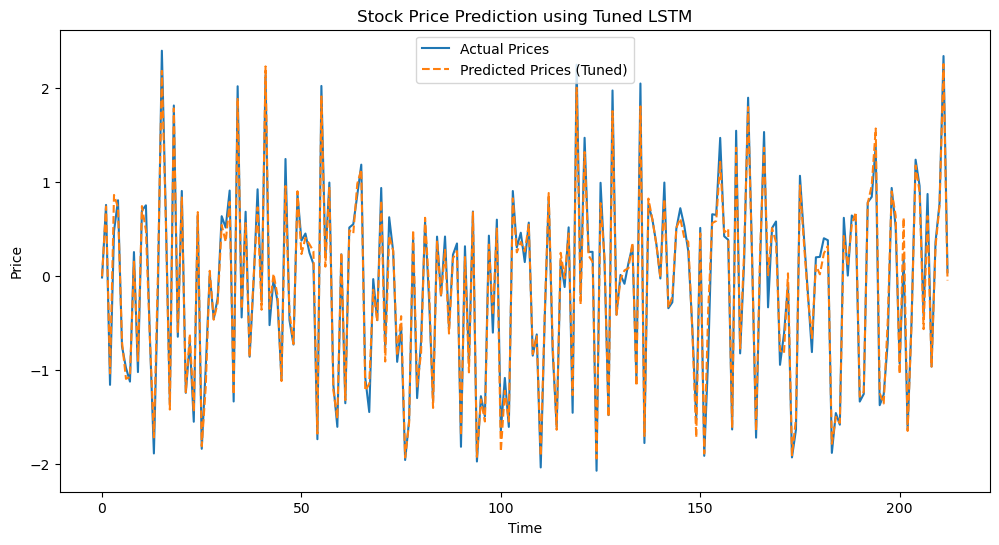

In [121]:

# lstm_predictions_model3 = lstm_predictions_model3[:, -1, 0]
# Plot the results for the tuned LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(lstm_predictions_model5, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Tuned LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [122]:
# Calculate metrics
mse5 = mean_squared_error(y_test, lstm_predictions_model5)
rmse5 = np.sqrt(mse5)
mae5 = mean_absolute_error(y_test, lstm_predictions_model5)
r2_5 = r2_score(y_test, lstm_predictions_model5)

#train metrics
y_train_pred5 = model5.predict(X_train)
train_mse5 = mean_squared_error(y_train, y_train_pred5)
train_r2_5 = r2_score(y_train, y_train_pred5)

#val metrics
y_val_pred5 = model5.predict(X_val)
val_mse5 = mean_squared_error(y_val, y_val_pred5)
val_r2_5 = r2_score(y_val, y_val_pred5)

# Output the results
print("Mean Squared Error (MSE):", mse5)
print("Root Mean Squared Error (RMSE):", rmse5)
print("Mean Absolute Error (MAE):", mae5)
print("R-squared (R²):", r2_5)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse5)
print("R-squared (R²):", train_r2_5)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse5)
print("R-squared (R²):", val_r2_5)# Calculate metrics

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Mean Squared Error (MSE): 0.015162359285463577
Root Mean Squared Error (RMSE): 0.12313553218085987
Mean Absolute Error (MAE): 0.09532200266196571
R-squared (R²): 0.9854464043614052
Training:

Mean Squared Error (MSE): 0.012676972898736318
R-squared (R²): 0.9874497055734515
Validation:

Mean Squared Error (MSE): 0.008802819356860947
R-squared (R²): 0.9915675714822981


In [123]:
#NEURAL NETWORKS
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten to (num_samples, 390)
X_test = X_test.reshape(X_test.shape[0], -1)     # Flatten to (num_samples, 390)
X_val = X_val.reshape(X_val.shape[0], -1)     

print(X_train.shape)
print(X_test.shape)
# Creating the Neural Network Model
NNmodel = Sequential()
# Input layer and Hidden layer
NNmodel.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='relu'))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel.compile(loss='mean_squared_error', optimizer='adam')

NNmodel.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


(681, 390)
(213, 390)
Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7608 - val_loss: 0.3946
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2725 - val_loss: 0.2533
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1669 - val_loss: 0.1816
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1049 - val_loss: 0.1497
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0678 - val_loss: 0.1215
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0555 - val_loss: 0.1065
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0465 - val_loss: 0.0948
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0356 - val_loss: 0.1100
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0389 - val_loss: 0.0810
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0291 - val_loss: 0.0751
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0254 - val_loss: 0.0708
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0222 - val_loss: 0.0656


In [124]:
NN_predictions_model = NNmodel.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


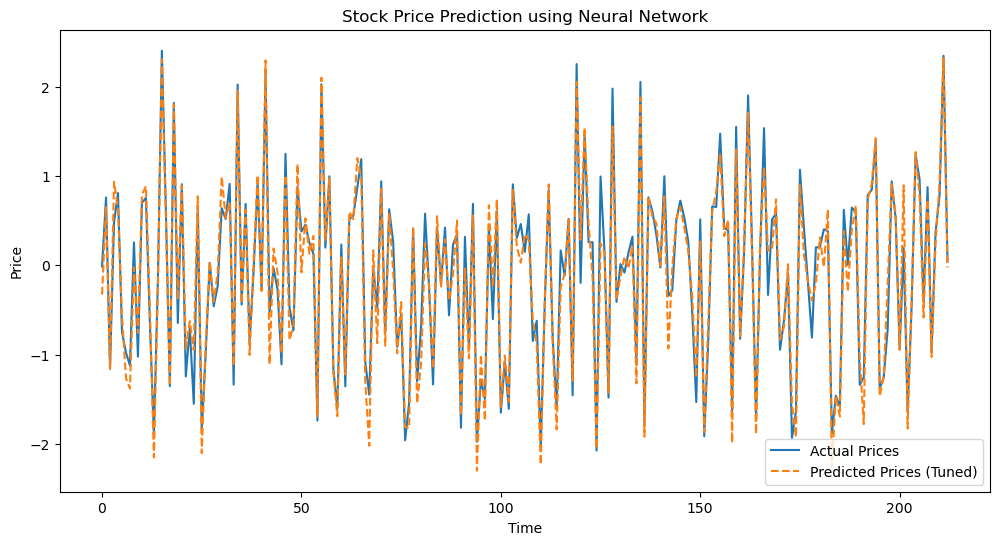

In [125]:

# Plot the results for the tuned NN model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(NN_predictions_model, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Neural Network')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [126]:
# Calculate metrics
mse_nn = mean_squared_error(y_test, NN_predictions_model)
rmse_nn = np.sqrt(mse_nn)
mae_nn = mean_absolute_error(y_test, NN_predictions_model)
r2_nn = r2_score(y_test, NN_predictions_model)

#train metrics
y_train_pred_nn = NNmodel.predict(X_train)
train_mse_nn = mean_squared_error(y_train, y_train_pred_nn)
train_r2_nn = r2_score(y_train, y_train_pred_nn)

#val metrics
y_val_pred_nn = NNmodel.predict(X_val)
val_mse_nn = mean_squared_error(y_val, y_val_pred_nn)
val_r2_nn = r2_score(y_val, y_val_pred_nn)

# Output the results
print("Mean Squared Error (MSE):", mse_nn)
print("Root Mean Squared Error (RMSE):", rmse_nn)
print("Mean Absolute Error (MAE):", mae_nn)
print("R-squared (R²):", r2_nn)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn)
print("R-squared (R²):", train_r2_nn)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn)
print("R-squared (R²):", val_r2_nn)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 0.053828074339868484
Root Mean Squared Error (RMSE): 0.23200878073872222
Mean Absolute Error (MAE): 0.18077832338143754
R-squared (R²): 0.9483331048158369
Training:

Mean Squared Error (MSE): 0.004371163148517637
R-squared (R²): 0.9956725170165944
Validation:

Mean Squared Error (MSE): 0.049556954887775326
R-squared (R²): 0.9525282227539478


In [127]:
# Creating the Neural Network Model
NNmodel2 = Sequential()
# Input layer and Hidden layer
# print(X.shape[2])
NNmodel2.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel2.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel2.compile(loss='mean_squared_error', optimizer='adam')

NNmodel2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

##############
NNmodel2_reg2 = Sequential()
# Input layer and Hidden layer
# print(X.shape[2])
NNmodel2_reg2.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.01)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel2_reg2.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel2_reg2.compile(loss='mean_squared_error', optimizer='adam')

NNmodel2_reg2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


##############
NNmodel2_reg3 = Sequential()
# Input layer and Hidden layer
# print(X.shape[2])
NNmodel2_reg3.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.05)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel2_reg3.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel2_reg3.compile(loss='mean_squared_error', optimizer='adam')

NNmodel2_reg3.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

##############
NNmodel2_reg4 = Sequential()
# Input layer and Hidden layer
# print(X.shape[2])
NNmodel2_reg4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.005)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel2_reg4.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel2_reg4.compile(loss='mean_squared_error', optimizer='adam')

NNmodel2_reg4.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

##############
NNmodel2_reg5 = Sequential()
# Input layer and Hidden layer
# print(X.shape[2])
NNmodel2_reg5.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.3)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel2_reg5.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel2_reg5.compile(loss='mean_squared_error', optimizer='adam')

NNmodel2_reg5.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


##############
NNmodel2_reg6 = Sequential()
# Input layer and Hidden layer
# print(X.shape[2])
NNmodel2_reg6.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.8)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel2_reg6.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel2_reg6.compile(loss='mean_squared_error', optimizer='adam')

NNmodel2_reg6.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))









Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8413 - val_loss: 4.9880
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.7797 - val_loss: 4.1519
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9745 - val_loss: 3.4514
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2955 - val_loss: 2.8466
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7089 - val_loss: 2.3308
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2174 - val_loss: 1.9038
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8063 - val_loss: 1.5515
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4746 - val_loss: 1.2627
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1983 - val_loss: 1.0291
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9767 - val_loss: 0.8559
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8063 - val_loss: 0.6897
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6574 - val_loss: 0.5712


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


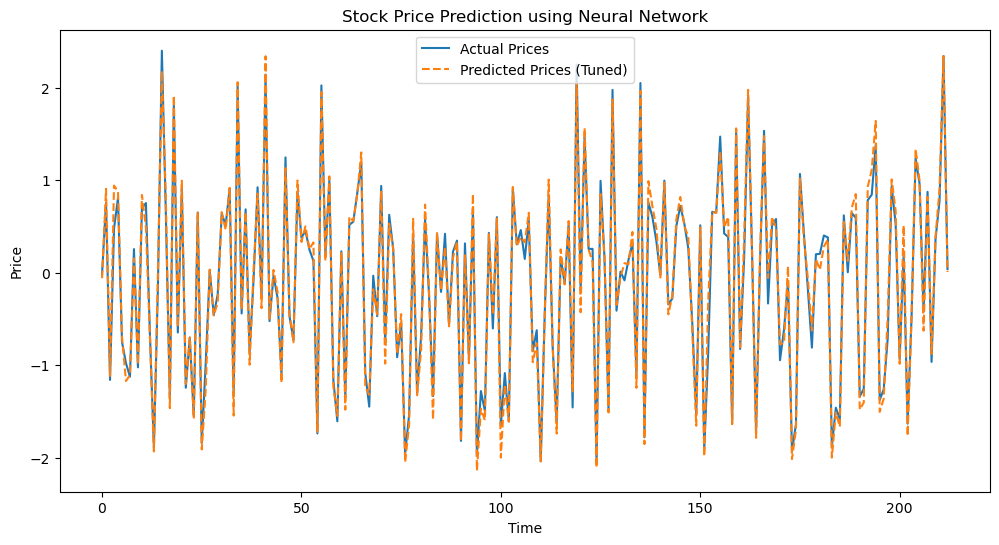

In [128]:
NN_predictions_model2 = NNmodel2.predict(X_test)
NN_predictions_model2_reg2 = NNmodel2_reg2.predict(X_test)
NN_predictions_model2_reg3 = NNmodel2_reg3.predict(X_test)
NN_predictions_model2_reg4 = NNmodel2_reg4.predict(X_test)
NN_predictions_model2_reg5 = NNmodel2_reg5.predict(X_test)
NN_predictions_model2_reg6 = NNmodel2_reg6.predict(X_test)




# Plot the results for the tuned NN model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(NN_predictions_model2, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Neural Network')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [129]:

# Calculate metrics
mse_nn2 = mean_squared_error(y_test, NN_predictions_model2)
rmse_nn2 = np.sqrt(mse_nn)
mae_nn2 = mean_absolute_error(y_test, NN_predictions_model2)
r2_nn2 = r2_score(y_test, NN_predictions_model2)

#train metrics
y_train_pred_nn2 = NNmodel2.predict(X_train)
# print(y_train_pred_nn2)
train_mse_nn2 = mean_squared_error(y_train, y_train_pred_nn2)
train_r2_nn2 = r2_score(y_train, y_train_pred_nn2)

#val metrics
y_val_pred_nn2 = NNmodel2.predict(X_val)
val_mse_nn2 = mean_squared_error(y_val, y_val_pred_nn2)
val_r2_nn2 = r2_score(y_val, y_val_pred_nn2)

# Output the results
print("Mean Squared Error (MSE):", mse_nn2)
print("R-squared (R²):", r2_nn2)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn2)
print("R-squared (R²):", train_r2_nn2)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn2)
print("R-squared (R²):", val_r2_nn2)

###########
# Calculate metrics
mse_nn2 = mean_squared_error(y_test, NN_predictions_model2_reg2)
rmse_nn2 = np.sqrt(mse_nn)
mae_nn2 = mean_absolute_error(y_test, NN_predictions_model2_reg2)
r2_nn2 = r2_score(y_test, NN_predictions_model2_reg2)

#train metrics
y_train_pred_nn2 = NNmodel2_reg2.predict(X_train)
# print(y_train_pred_nn2)
train_mse_nn2 = mean_squared_error(y_train, y_train_pred_nn2)
train_r2_nn2 = r2_score(y_train, y_train_pred_nn2)

#val metrics
y_val_pred_nn2 = NNmodel2_reg2.predict(X_val)
val_mse_nn2 = mean_squared_error(y_val, y_val_pred_nn2)
val_r2_nn2 = r2_score(y_val, y_val_pred_nn2)

# Output the results
print("Mean Squared Error (MSE):", mse_nn2)
print("R-squared (R²):", r2_nn2)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn2)
print("R-squared (R²):", train_r2_nn2)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn2)
print("R-squared (R²):", val_r2_nn2)

###########
# Calculate metrics
mse_nn2 = mean_squared_error(y_test, NN_predictions_model2_reg3)
rmse_nn2 = np.sqrt(mse_nn)
mae_nn2 = mean_absolute_error(y_test, NN_predictions_model2_reg3)
r2_nn2 = r2_score(y_test, NN_predictions_model2_reg3)

#train metrics
y_train_pred_nn2 = NNmodel2_reg3.predict(X_train)
# print(y_train_pred_nn2)
train_mse_nn2 = mean_squared_error(y_train, y_train_pred_nn2)
train_r2_nn2 = r2_score(y_train, y_train_pred_nn2)

#val metrics
y_val_pred_nn2 = NNmodel2_reg3.predict(X_val)
val_mse_nn2 = mean_squared_error(y_val, y_val_pred_nn2)
val_r2_nn2 = r2_score(y_val, y_val_pred_nn2)

# Output the results
print("Mean Squared Error (MSE):", mse_nn2)
print("R-squared (R²):", r2_nn2)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn2)
print("R-squared (R²):", train_r2_nn2)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn2)
print("R-squared (R²):", val_r2_nn2)



###########
# Calculate metrics
mse_nn2 = mean_squared_error(y_test, NN_predictions_model2_reg4)
rmse_nn2 = np.sqrt(mse_nn)
mae_nn2 = mean_absolute_error(y_test, NN_predictions_model2_reg4)
r2_nn2 = r2_score(y_test, NN_predictions_model2_reg4)

#train metrics
y_train_pred_nn2 = NNmodel2_reg4.predict(X_train)
# print(y_train_pred_nn2)
train_mse_nn2 = mean_squared_error(y_train, y_train_pred_nn2)
train_r2_nn2 = r2_score(y_train, y_train_pred_nn2)

#val metrics
y_val_pred_nn2 = NNmodel2_reg4.predict(X_val)
val_mse_nn2 = mean_squared_error(y_val, y_val_pred_nn2)
val_r2_nn2 = r2_score(y_val, y_val_pred_nn2)

# Output the results
print("Mean Squared Error (MSE):", mse_nn2)
print("R-squared (R²):", r2_nn2)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn2)
print("R-squared (R²):", train_r2_nn2)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn2)
print("R-squared (R²):", val_r2_nn2)

###########
# Calculate metrics
mse_nn2 = mean_squared_error(y_test, NN_predictions_model2_reg5)
rmse_nn2 = np.sqrt(mse_nn)
mae_nn2 = mean_absolute_error(y_test, NN_predictions_model2_reg5)
r2_nn2 = r2_score(y_test, NN_predictions_model2_reg5)

#train metrics
y_train_pred_nn2 = NNmodel2_reg5.predict(X_train)
# print(y_train_pred_nn2)
train_mse_nn2 = mean_squared_error(y_train, y_train_pred_nn2)
train_r2_nn2 = r2_score(y_train, y_train_pred_nn2)

#val metrics
y_val_pred_nn2 = NNmodel2_reg5.predict(X_val)
val_mse_nn2 = mean_squared_error(y_val, y_val_pred_nn2)
val_r2_nn2 = r2_score(y_val, y_val_pred_nn2)

# Output the results
print("Mean Squared Error (MSE):", mse_nn2)
print("R-squared (R²):", r2_nn2)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn2)
print("R-squared (R²):", train_r2_nn2)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn2)
print("R-squared (R²):", val_r2_nn2)

###########
# Calculate metrics
mse_nn2 = mean_squared_error(y_test, NN_predictions_model2_reg6)
rmse_nn2 = np.sqrt(mse_nn)
mae_nn2 = mean_absolute_error(y_test, NN_predictions_model2_reg6)
r2_nn2 = r2_score(y_test, NN_predictions_model2_reg6)

#train metrics
y_train_pred_nn2 = NNmodel2_reg6.predict(X_train)
# print(y_train_pred_nn2)
train_mse_nn2 = mean_squared_error(y_train, y_train_pred_nn2)
train_r2_nn2 = r2_score(y_train, y_train_pred_nn2)

#val metrics
y_val_pred_nn2 = NNmodel2_reg6.predict(X_val)
val_mse_nn2 = mean_squared_error(y_val, y_val_pred_nn2)
val_r2_nn2 = r2_score(y_val, y_val_pred_nn2)

# Output the results
print("Mean Squared Error (MSE):", mse_nn2)
print("R-squared (R²):", r2_nn2)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn2)
print("R-squared (R²):", train_r2_nn2)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn2)
print("R-squared (R²):", val_r2_nn2)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 0.016087556974095977
R-squared (R²): 0.984558353050088
Training:

Mean Squared Error (MSE): 0.0120720439261787
R-squared (R²): 0.9880485896109416
Validation:

Mean Squared Error (MSE): 0.010304414992761494
R-squared (R²): 0.9901291575663798
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 0.018916324371902906
R-squared (R²): 0.9818431597158427
Training:

Mean Squared Error (MSE): 0.008130513862666194
R-squared (R²): 0.9919507327474237
Validation:

Mean Squared Error (MSE): 0.01454536180854841
R-squared (R²): 0.9860666544725698
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 0.016354283918153585
R-squared (R²): 0.9843023351034974
Training:

Mean Squared Error (MSE): 0.01029086240898889
R-squared (R²): 0.9898119721350208
Validation:

Mean Squared Error (MSE): 0.011986601257249

In [130]:
NNmodel3 = Sequential()
# Input layer and Hidden layer
NNmodel3.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel3.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))

NNmodel3.add(Dense(1))  # No activation function for regression output
# Compile/build the model

NNmodel3.compile(loss='mean_squared_error', optimizer='adam')
# optimizer = Adam()
# print(optimizer.learning_rate.numpy())  # Output: 0.001


NNmodel3.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


###############
NNmodel3_reg2 = Sequential()
# Input layer and Hidden layer
NNmodel3_reg2.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.01)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel3_reg2.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.01)))

NNmodel3_reg2.add(Dense(1))  # No activation function for regression output
# Compile/build the model

NNmodel3_reg2.compile(loss='mean_squared_error', optimizer='adam')
# optimizer = Adam()
# print(optimizer.learning_rate.numpy())  # Output: 0.001


NNmodel3_reg2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


###############
NNmodel3_reg3 = Sequential()
# Input layer and Hidden layer
NNmodel3_reg3.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.005)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel3_reg3.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.005)))

NNmodel3_reg3.add(Dense(1))  # No activation function for regression output
# Compile/build the model

NNmodel3_reg3.compile(loss='mean_squared_error', optimizer='adam')
# optimizer = Adam()
# print(optimizer.learning_rate.numpy())  # Output: 0.001


NNmodel3_reg3.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


###############
NNmodel3_reg4 = Sequential()
# Input layer and Hidden layer
NNmodel3_reg4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.05)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel3_reg4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.05)))

NNmodel3_reg4.add(Dense(1))  # No activation function for regression output
# Compile/build the model

NNmodel3_reg4.compile(loss='mean_squared_error', optimizer='adam')
# optimizer = Adam()
# print(optimizer.learning_rate.numpy())  # Output: 0.001


NNmodel3_reg4.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


###############
NNmodel3_reg5 = Sequential()
# Input layer and Hidden layer
NNmodel3_reg5.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.3)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel3_reg5.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.3)))

NNmodel3_reg5.add(Dense(1))  # No activation function for regression output
# Compile/build the model

NNmodel3_reg5.compile(loss='mean_squared_error', optimizer='adam')
# optimizer = Adam()
# print(optimizer.learning_rate.numpy())  # Output: 0.001


NNmodel3_reg5.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


###############
NNmodel3_reg6 = Sequential()
# Input layer and Hidden layer
NNmodel3_reg6.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.5)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel3_reg6.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.5)))

NNmodel3_reg6.add(Dense(1))  # No activation function for regression output
# Compile/build the model

NNmodel3_reg6.compile(loss='mean_squared_error', optimizer='adam')
# optimizer = Adam()
# print(optimizer.learning_rate.numpy())  # Output: 0.001


NNmodel3_reg6.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))






Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.3977 - val_loss: 7.9246
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6821 - val_loss: 6.9805
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.7538 - val_loss: 6.0925
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8866 - val_loss: 5.3129
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1340 - val_loss: 4.6269
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4769 - val_loss: 4.0308
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8971 - val_loss: 3.5139
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4014 - val_loss: 3.0709
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9782 - val_loss: 2.6929
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6141 - val_loss: 2.3681
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3001 - val_loss: 2.0895
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0292 - val_loss: 1.8442


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


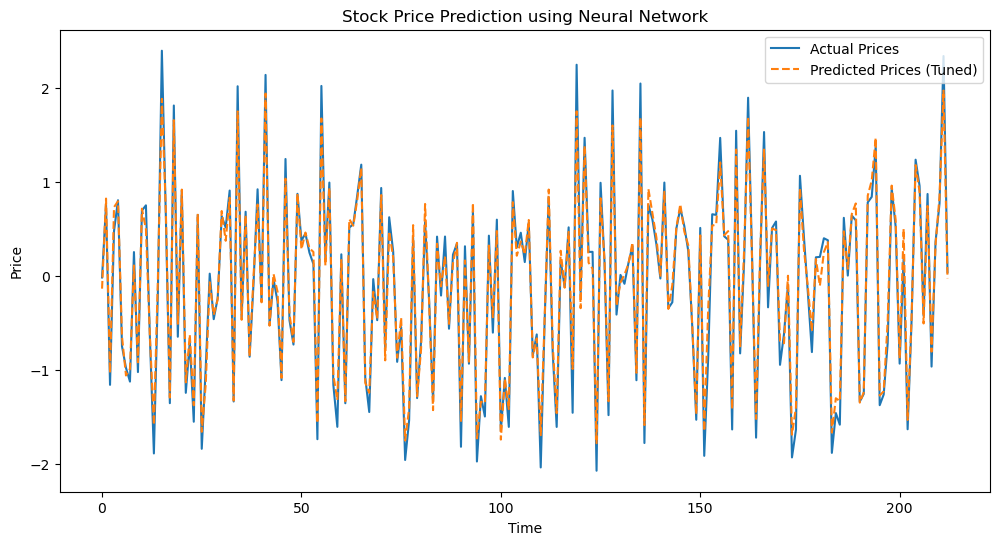

In [131]:
NN_predictions_model3 = NNmodel3.predict(X_test)
NN_predictions_model3_reg2 = NNmodel3_reg2.predict(X_test)
NN_predictions_model3_reg3 = NNmodel3_reg3.predict(X_test)
NN_predictions_model3_reg4 = NNmodel3_reg4.predict(X_test)
NN_predictions_model3_reg5 = NNmodel3_reg5.predict(X_test)
NN_predictions_model3_reg6 = NNmodel3_reg6.predict(X_test)



# Plot the results for the tuned NN model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(NN_predictions_model3, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Neural Network')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [132]:
# Calculate metrics
mse_nn3 = mean_squared_error(y_test, NN_predictions_model3)
rmse_nn3 = np.sqrt(mse_nn3)
mae_nn3 = mean_absolute_error(y_test, NN_predictions_model3)
r2_nn3 = r2_score(y_test, NN_predictions_model3)

#train metrics
y_train_pred_nn3 = NNmodel3.predict(X_train)
train_mse_nn3 = mean_squared_error(y_train, y_train_pred_nn3)
train_r2_nn3 = r2_score(y_train, y_train_pred_nn3)

#val metrics
y_val_pred_nn3 = NNmodel3.predict(X_val)
val_mse_nn3 = mean_squared_error(y_val, y_val_pred_nn3)
val_r2_nn3 = r2_score(y_val, y_val_pred_nn3)

# Output the results
print("Mean Squared Error (MSE):", mse_nn3)
print("R-squared (R²):", r2_nn3)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn3)
print("R-squared (R²):", train_r2_nn3)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn3)
print("R-squared (R²):", val_r2_nn3)


#############
# Calculate metrics
mse_nn3 = mean_squared_error(y_test, NN_predictions_model3_reg2)
rmse_nn3 = np.sqrt(mse_nn3)
mae_nn3 = mean_absolute_error(y_test, NN_predictions_model3_reg2)
r2_nn3 = r2_score(y_test, NN_predictions_model3_reg2)

#train metrics
y_train_pred_nn3 = NNmodel3_reg2.predict(X_train)
train_mse_nn3 = mean_squared_error(y_train, y_train_pred_nn3)
train_r2_nn3 = r2_score(y_train, y_train_pred_nn3)

#val metrics
y_val_pred_nn3 = NNmodel3_reg2.predict(X_val)
val_mse_nn3 = mean_squared_error(y_val, y_val_pred_nn3)
val_r2_nn3 = r2_score(y_val, y_val_pred_nn3)

# Output the results
print("Mean Squared Error (MSE):", mse_nn3)
print("R-squared (R²):", r2_nn3)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn3)
print("R-squared (R²):", train_r2_nn3)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn3)
print("R-squared (R²):", val_r2_nn3)

#############
# Calculate metrics
mse_nn3 = mean_squared_error(y_test, NN_predictions_model3_reg3)
rmse_nn3 = np.sqrt(mse_nn3)
mae_nn3 = mean_absolute_error(y_test, NN_predictions_model3_reg3)
r2_nn3 = r2_score(y_test, NN_predictions_model3_reg3)

#train metrics
y_train_pred_nn3 = NNmodel3_reg3.predict(X_train)
train_mse_nn3 = mean_squared_error(y_train, y_train_pred_nn3)
train_r2_nn3 = r2_score(y_train, y_train_pred_nn3)

#val metrics
y_val_pred_nn3 = NNmodel3_reg3.predict(X_val)
val_mse_nn3 = mean_squared_error(y_val, y_val_pred_nn3)
val_r2_nn3 = r2_score(y_val, y_val_pred_nn3)

# Output the results
print("Mean Squared Error (MSE):", mse_nn3)
print("R-squared (R²):", r2_nn3)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn3)
print("R-squared (R²):", train_r2_nn3)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn3)
print("R-squared (R²):", val_r2_nn3)


#############
# Calculate metrics
mse_nn3 = mean_squared_error(y_test, NN_predictions_model3_reg4)
rmse_nn3 = np.sqrt(mse_nn3)
mae_nn3 = mean_absolute_error(y_test, NN_predictions_model3_reg4)
r2_nn3 = r2_score(y_test, NN_predictions_model3_reg4)

#train metrics
y_train_pred_nn3 = NNmodel3_reg4.predict(X_train)
train_mse_nn3 = mean_squared_error(y_train, y_train_pred_nn3)
train_r2_nn3 = r2_score(y_train, y_train_pred_nn3)

#val metrics
y_val_pred_nn3 = NNmodel3_reg4.predict(X_val)
val_mse_nn3 = mean_squared_error(y_val, y_val_pred_nn3)
val_r2_nn3 = r2_score(y_val, y_val_pred_nn3)

# Output the results
print("Mean Squared Error (MSE):", mse_nn3)
print("R-squared (R²):", r2_nn3)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn3)
print("R-squared (R²):", train_r2_nn3)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn3)
print("R-squared (R²):", val_r2_nn3)


#############
# Calculate metrics
mse_nn3 = mean_squared_error(y_test, NN_predictions_model3_reg5)
rmse_nn3 = np.sqrt(mse_nn3)
mae_nn3 = mean_absolute_error(y_test, NN_predictions_model3_reg5)
r2_nn3 = r2_score(y_test, NN_predictions_model3_reg5)

#train metrics
y_train_pred_nn3 = NNmodel3_reg5.predict(X_train)
train_mse_nn3 = mean_squared_error(y_train, y_train_pred_nn3)
train_r2_nn3 = r2_score(y_train, y_train_pred_nn3)

#val metrics
y_val_pred_nn3 = NNmodel3_reg5.predict(X_val)
val_mse_nn3 = mean_squared_error(y_val, y_val_pred_nn3)
val_r2_nn3 = r2_score(y_val, y_val_pred_nn3)

# Output the results
print("Mean Squared Error (MSE):", mse_nn3)
print("R-squared (R²):", r2_nn3)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn3)
print("R-squared (R²):", train_r2_nn3)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn3)
print("R-squared (R²):", val_r2_nn3)



#############
# Calculate metrics
mse_nn3 = mean_squared_error(y_test, NN_predictions_model3_reg6)
rmse_nn3 = np.sqrt(mse_nn3)
mae_nn3 = mean_absolute_error(y_test, NN_predictions_model3_reg6)
r2_nn3 = r2_score(y_test, NN_predictions_model3_reg6)

#train metrics
y_train_pred_nn3 = NNmodel3_reg6.predict(X_train)
train_mse_nn3 = mean_squared_error(y_train, y_train_pred_nn3)
train_r2_nn3 = r2_score(y_train, y_train_pred_nn3)

#val metrics
y_val_pred_nn3 = NNmodel3_reg6.predict(X_val)
val_mse_nn3 = mean_squared_error(y_val, y_val_pred_nn3)
val_r2_nn3 = r2_score(y_val, y_val_pred_nn3)

# Output the results
print("Mean Squared Error (MSE):", mse_nn3)
print("R-squared (R²):", r2_nn3)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn3)
print("R-squared (R²):", train_r2_nn3)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn3)
print("R-squared (R²):", val_r2_nn3)



22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 0.02356041440576282
R-squared (R²): 0.9773855283413624
Training:

Mean Squared Error (MSE): 0.02042145656239825
R-squared (R²): 0.9797826109967768
Validation:

Mean Squared Error (MSE): 0.018599044447913732
R-squared (R²): 0.9821835361551122
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 0.016299239569140492
R-squared (R²): 0.9843551694403341
Training:

Mean Squared Error (MSE): 0.006946623360388909
R-squared (R²): 0.9931227928670644
Validation:

Mean Squared Error (MSE): 0.011109367524459861
R-squared (R²): 0.9893580745293981
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean Squared Error (MSE): 0.01980644270302039
R-squared (R²): 0.9809887793375855
Training:

Mean Squared Error (MSE): 0.004948240379652259
R-squared (R²): 0.9951012064036073
Validation:

Mean Squared Error (MSE): 0.016390819432107

In [133]:
NNmodel4 = Sequential()
# Input layer and Hidden layer
NNmodel4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))
NNmodel4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='relu', kernel_regularizer=l2(0.1)))
NNmodel4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='sigmoid', kernel_regularizer=l2(0.1)))
NNmodel4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))

NNmodel4.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel4.compile(loss='mean_squared_error', optimizer='adam')

NNmodel4.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

#############
NNmodel4_reg2 = Sequential()
# Input layer and Hidden layer
NNmodel4_reg2.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.05)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel4_reg2.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.05)))
NNmodel4_reg2.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='relu', kernel_regularizer=l2(0.05)))
NNmodel4_reg2.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='sigmoid', kernel_regularizer=l2(0.05)))
NNmodel4_reg2.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.05)))

NNmodel4_reg2.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel4_reg2.compile(loss='mean_squared_error', optimizer='adam')

NNmodel4_reg2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


#############
NNmodel4_reg3 = Sequential()
# Input layer and Hidden layer
NNmodel4_reg3.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.01)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel4_reg3.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.01)))
NNmodel4_reg3.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='relu', kernel_regularizer=l2(0.01)))
NNmodel4_reg3.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='sigmoid', kernel_regularizer=l2(0.01)))
NNmodel4_reg3.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.01)))

NNmodel4_reg3.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel4_reg3.compile(loss='mean_squared_error', optimizer='adam')

NNmodel4_reg3.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


#############
NNmodel4_reg4 = Sequential()
# Input layer and Hidden layer
NNmodel4_reg4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.3)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel4_reg4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.3)))
NNmodel4_reg4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='relu', kernel_regularizer=l2(0.3)))
NNmodel4_reg4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='sigmoid', kernel_regularizer=l2(0.3)))
NNmodel4_reg4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.3)))

NNmodel4_reg4.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel4_reg4.compile(loss='mean_squared_error', optimizer='adam')

NNmodel4_reg4.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


#############
NNmodel4_reg5 = Sequential()
# Input layer and Hidden layer
NNmodel4_reg5.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.5)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel4_reg5.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.5)))
NNmodel4_reg5.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='relu', kernel_regularizer=l2(0.5)))
NNmodel4_reg5.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='sigmoid', kernel_regularizer=l2(0.5)))
NNmodel4_reg5.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.5)))

NNmodel4_reg5.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel4_reg5.compile(loss='mean_squared_error', optimizer='adam')

NNmodel4_reg5.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))




#############
NNmodel4_reg6 = Sequential()
# Input layer and Hidden layer
NNmodel4_reg6.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.8)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel4_reg6.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.8)))
NNmodel4_reg6.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='relu', kernel_regularizer=l2(0.8)))
NNmodel4_reg6.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='sigmoid', kernel_regularizer=l2(0.8)))
NNmodel4_reg6.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.8)))

NNmodel4_reg6.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel4_reg6.compile(loss='mean_squared_error', optimizer='adam')

NNmodel4_reg6.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))



Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 17.5994 - val_loss: 15.6814
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.1150 - val_loss: 13.4519
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.9352 - val_loss: 11.5589
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.1239 - val_loss: 9.9971
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6443 - val_loss: 8.6831
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4047 - val_loss: 7.5899
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.3510 - val_loss: 6.6772
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4560 - val_loss: 5.8863
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7182 - val_loss: 5.2182
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0634 - val_loss: 4.6576
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5385 - val_loss: 4.1504
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0390 - val_loss:

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


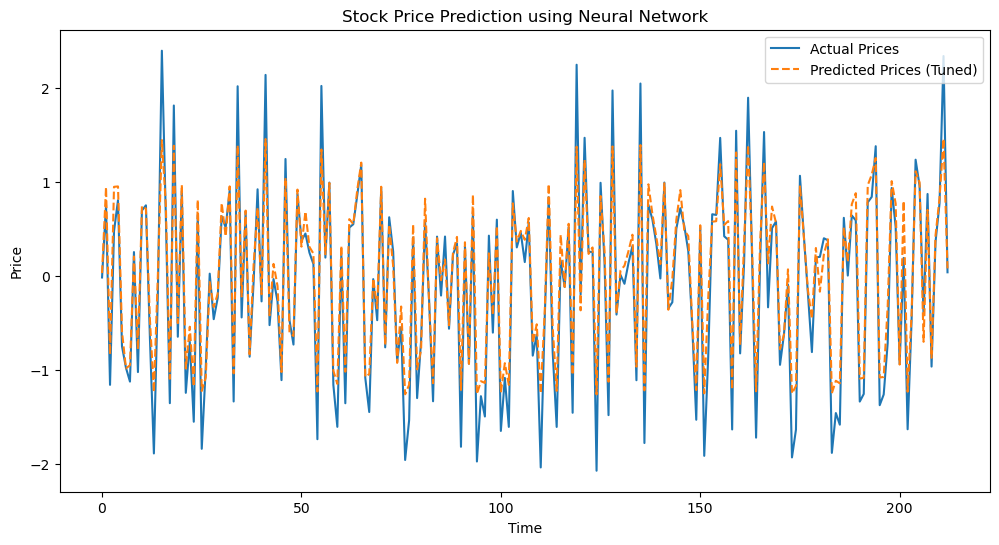

In [134]:
NN_predictions_model4 = NNmodel4.predict(X_test)
NN_predictions_model4_reg2 = NNmodel4_reg2.predict(X_test)
NN_predictions_model4_reg3 = NNmodel4_reg3.predict(X_test)
NN_predictions_model4_reg4 = NNmodel4_reg4.predict(X_test)
NN_predictions_model4_reg5 = NNmodel4_reg5.predict(X_test)
NN_predictions_model4_reg6 = NNmodel4_reg6.predict(X_test)

# Plot the results for the tuned NN model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(NN_predictions_model4, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Neural Network')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [135]:
# Calculate metrics
mse_nn4 = mean_squared_error(y_test, NN_predictions_model4)
rmse_nn4 = np.sqrt(mse_nn4)
mae_nn4 = mean_absolute_error(y_test, NN_predictions_model4)
r2_nn4 = r2_score(y_test, NN_predictions_model4)

#train metrics
y_train_pred_nn4 = NNmodel4.predict(X_train)
train_mse_nn4 = mean_squared_error(y_train, y_train_pred_nn4)
train_r2_nn4 = r2_score(y_train, y_train_pred_nn4)

#val metrics
y_val_pred_nn4 = NNmodel4.predict(X_val)
val_mse_nn4 = mean_squared_error(y_val, y_val_pred_nn4)
val_r2_nn4 = r2_score(y_val, y_val_pred_nn4)

# Output the results
print("Mean Squared Error (MSE):", mse_nn4)

print("R-squared (R²):", r2_nn4)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn4)
print("R-squared (R²):", train_r2_nn4)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn4)
print("R-squared (R²):", val_r2_nn4)

###########
# Calculate metrics
mse_nn4 = mean_squared_error(y_test, NN_predictions_model4_reg2)
rmse_nn4 = np.sqrt(mse_nn4)
mae_nn4 = mean_absolute_error(y_test, NN_predictions_model4_reg2)
r2_nn4 = r2_score(y_test, NN_predictions_model4_reg2)

#train metrics
y_train_pred_nn4 = NNmodel4_reg2.predict(X_train)
train_mse_nn4 = mean_squared_error(y_train, y_train_pred_nn4)
train_r2_nn4 = r2_score(y_train, y_train_pred_nn4)

#val metrics
y_val_pred_nn4 = NNmodel4_reg2.predict(X_val)
val_mse_nn4 = mean_squared_error(y_val, y_val_pred_nn4)
val_r2_nn4 = r2_score(y_val, y_val_pred_nn4)

# Output the results
print("Mean Squared Error (MSE):", mse_nn4)

print("R-squared (R²):", r2_nn4)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn4)
print("R-squared (R²):", train_r2_nn4)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn4)
print("R-squared (R²):", val_r2_nn4)


###########
# Calculate metrics
mse_nn4 = mean_squared_error(y_test, NN_predictions_model4_reg3)
rmse_nn4 = np.sqrt(mse_nn4)
mae_nn4 = mean_absolute_error(y_test, NN_predictions_model4_reg3)
r2_nn4 = r2_score(y_test, NN_predictions_model4_reg3)

#train metrics
y_train_pred_nn4 = NNmodel4_reg3.predict(X_train)
train_mse_nn4 = mean_squared_error(y_train, y_train_pred_nn4)
train_r2_nn4 = r2_score(y_train, y_train_pred_nn4)

#val metrics
y_val_pred_nn4 = NNmodel4_reg3.predict(X_val)
val_mse_nn4 = mean_squared_error(y_val, y_val_pred_nn4)
val_r2_nn4 = r2_score(y_val, y_val_pred_nn4)

# Output the results
print("Mean Squared Error (MSE):", mse_nn4)

print("R-squared (R²):", r2_nn4)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn4)
print("R-squared (R²):", train_r2_nn4)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn4)
print("R-squared (R²):", val_r2_nn4)


###########
# Calculate metrics
mse_nn4 = mean_squared_error(y_test, NN_predictions_model4_reg4)
rmse_nn4 = np.sqrt(mse_nn4)
mae_nn4 = mean_absolute_error(y_test, NN_predictions_model4_reg4)
r2_nn4 = r2_score(y_test, NN_predictions_model4_reg4)

#train metrics
y_train_pred_nn4 = NNmodel4_reg4.predict(X_train)
train_mse_nn4 = mean_squared_error(y_train, y_train_pred_nn4)
train_r2_nn4 = r2_score(y_train, y_train_pred_nn4)

#val metrics
y_val_pred_nn4 = NNmodel4_reg4.predict(X_val)
val_mse_nn4 = mean_squared_error(y_val, y_val_pred_nn4)
val_r2_nn4 = r2_score(y_val, y_val_pred_nn4)

# Output the results
print("Mean Squared Error (MSE):", mse_nn4)

print("R-squared (R²):", r2_nn4)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn4)
print("R-squared (R²):", train_r2_nn4)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn4)
print("R-squared (R²):", val_r2_nn4)


###########
# Calculate metrics
mse_nn4 = mean_squared_error(y_test, NN_predictions_model4_reg5)
rmse_nn4 = np.sqrt(mse_nn4)
mae_nn4 = mean_absolute_error(y_test, NN_predictions_model4_reg5)
r2_nn4 = r2_score(y_test, NN_predictions_model4_reg5)

#train metrics
y_train_pred_nn4 = NNmodel4_reg5.predict(X_train)
train_mse_nn4 = mean_squared_error(y_train, y_train_pred_nn4)
train_r2_nn4 = r2_score(y_train, y_train_pred_nn4)

#val metrics
y_val_pred_nn4 = NNmodel4_reg5.predict(X_val)
val_mse_nn4 = mean_squared_error(y_val, y_val_pred_nn4)
val_r2_nn4 = r2_score(y_val, y_val_pred_nn4)

# Output the results
print("Mean Squared Error (MSE):", mse_nn4)

print("R-squared (R²):", r2_nn4)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn4)
print("R-squared (R²):", train_r2_nn4)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn4)
print("R-squared (R²):", val_r2_nn4)

###########
# Calculate metrics
mse_nn4 = mean_squared_error(y_test, NN_predictions_model4_reg6)
rmse_nn4 = np.sqrt(mse_nn4)
mae_nn4 = mean_absolute_error(y_test, NN_predictions_model4_reg6)
r2_nn4 = r2_score(y_test, NN_predictions_model4_reg6)

#train metrics
y_train_pred_nn4 = NNmodel4_reg6.predict(X_train)
train_mse_nn4 = mean_squared_error(y_train, y_train_pred_nn4)
train_r2_nn4 = r2_score(y_train, y_train_pred_nn4)

#val metrics
y_val_pred_nn4 = NNmodel4_reg6.predict(X_val)
val_mse_nn4 = mean_squared_error(y_val, y_val_pred_nn4)
val_r2_nn4 = r2_score(y_val, y_val_pred_nn4)

# Output the results
print("Mean Squared Error (MSE):", mse_nn4)

print("R-squared (R²):", r2_nn4)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn4)
print("R-squared (R²):", train_r2_nn4)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn4)
print("R-squared (R²):", val_r2_nn4)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 0.08691497714013717
R-squared (R²): 0.9165746300809547
Training:

Mean Squared Error (MSE): 0.07465555134928092
R-squared (R²): 0.9260904667467431
Validation:

Mean Squared Error (MSE): 0.07532010726015999
R-squared (R²): 0.927849090766368
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 0.054290554872754894
R-squared (R²): 0.9478891927214438
Training:

Mean Squared Error (MSE): 0.05009071665231029
R-squared (R²): 0.9504098299298267
Validation:

Mean Squared Error (MSE): 0.045448346561114975
R-squared (R²): 0.9564639556841931
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean Squared Error (MSE): 0.03325626342208608
R-squared (R²): 0.9680789644155412
Training:

Mean Squared Error (MSE): 0.026448076404445808
R-squared (R²): 0.9738162139697614
Validation:

Mean Squared Error (MSE): 0.0291966591284958

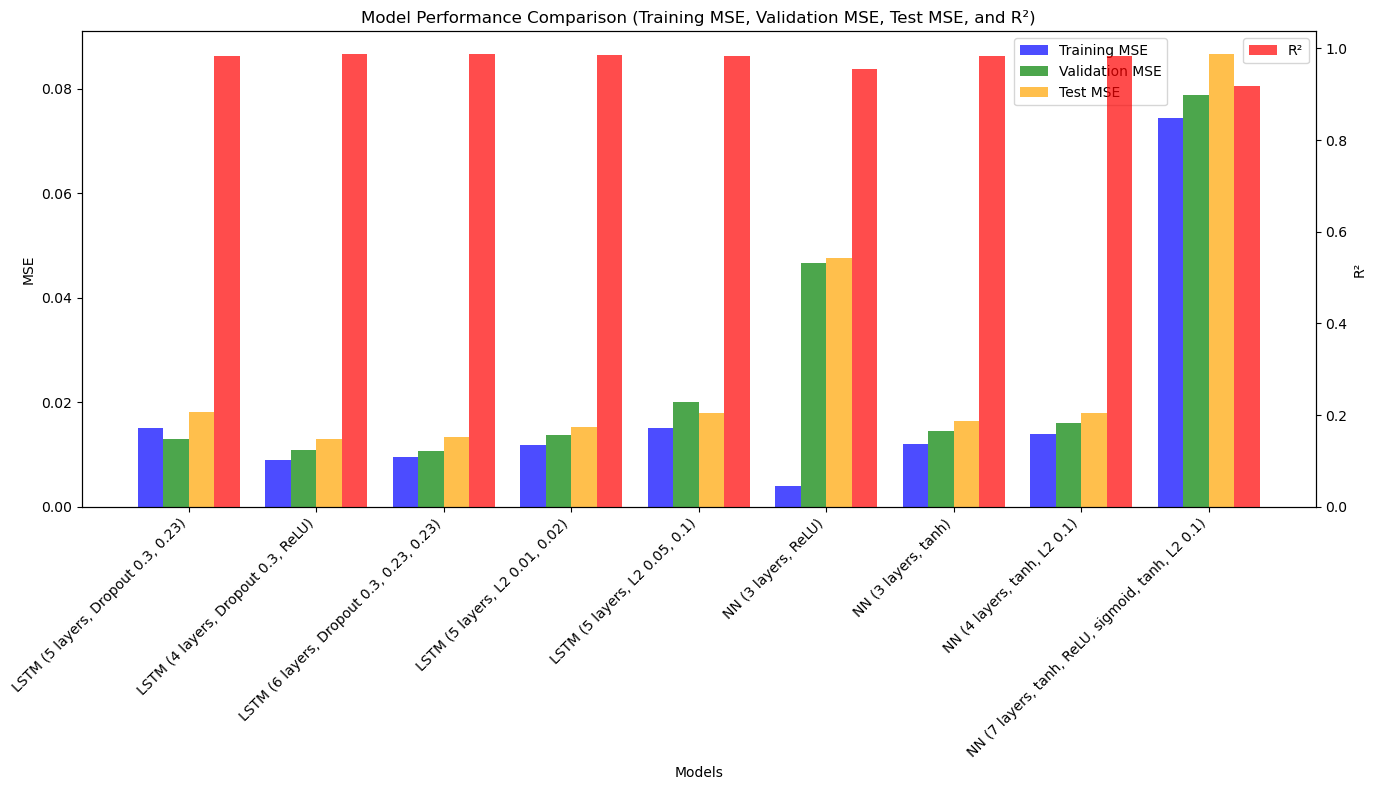

In [136]:
# Data
models = [
    "LSTM (5 layers, Dropout 0.3, 0.23)",
    "LSTM (4 layers, Dropout 0.3, ReLU)",
    "LSTM (6 layers, Dropout 0.3, 0.23, 0.23)",
    "LSTM (5 layers, L2 0.01, 0.02)",
    "LSTM (5 layers, L2 0.05, 0.1)",
    "NN (3 layers, ReLU)",
    "NN (3 layers, tanh)",
    "NN (4 layers, tanh, L2 0.1)",
    "NN (7 layers, tanh, ReLU, sigmoid, tanh, L2 0.1)"
]

training_mse = [0.0151, 0.0089, 0.0095, 0.0118, 0.0151, 0.0039, 0.0121, 0.0139, 0.0744]
validation_mse = [0.0129, 0.0108, 0.0107, 0.0138, 0.0201, 0.0467, 0.0145, 0.0161, 0.0788]
test_mse = [0.0182, 0.0129, 0.0133, 0.0152, 0.0180, 0.0477, 0.0165, 0.0179, 0.0867]
r2 = [0.9827, 0.9877, 0.9874, 0.9856, 0.9829, 0.9546, 0.9843, 0.9830, 0.9176]

# Plotting
x = np.arange(len(models))  # x-axis positions
width = 0.2  # Width of the bars

fig, ax1 = plt.subplots(figsize=(14, 8))

# Training MSE Plot
ax1.bar(x - width*1.5, training_mse, width, label='Training MSE', color='blue', alpha=0.7)

# Validation MSE Plot
ax1.bar(x - width/2, validation_mse, width, label='Validation MSE', color='green', alpha=0.7)

# Test MSE Plot
ax1.bar(x + width/2, test_mse, width, label='Test MSE', color='orange', alpha=0.7)

# R² Plot (right y-axis)
ax2 = ax1.twinx()
ax2.bar(x + width*1.5, r2, width, label='R²', color='red', alpha=0.7)

# Labels and Titles
ax1.set_xlabel('Models')
ax1.set_ylabel('MSE', color='black')
ax2.set_ylabel('R²', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.set_title('Model Performance Comparison (Training MSE, Validation MSE, Test MSE, and R²)')

# Legends
ax1.legend(loc='upper left', bbox_to_anchor=(0.75, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Adjust layout
fig.tight_layout()
plt.show()


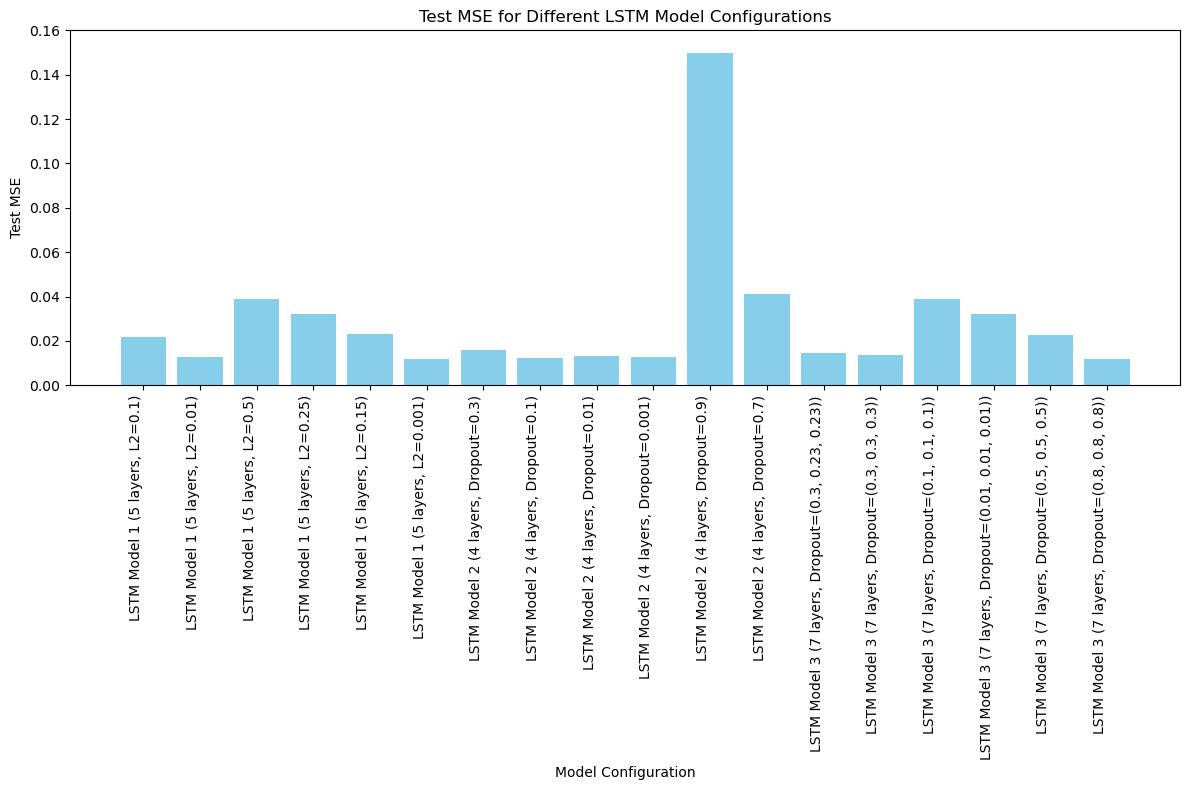

In [137]:
# Data
models = [
    "LSTM Model 1 (5 layers, L2=0.1)",
    "LSTM Model 1 (5 layers, L2=0.01)",
    "LSTM Model 1 (5 layers, L2=0.5)",
    "LSTM Model 1 (5 layers, L2=0.25)",
    "LSTM Model 1 (5 layers, L2=0.15)",
    "LSTM Model 1 (5 layers, L2=0.001)",
    "LSTM Model 2 (4 layers, Dropout=0.3)",
    "LSTM Model 2 (4 layers, Dropout=0.1)",
    "LSTM Model 2 (4 layers, Dropout=0.01)",
    "LSTM Model 2 (4 layers, Dropout=0.001)",
    "LSTM Model 2 (4 layers, Dropout=0.9)",
    "LSTM Model 2 (4 layers, Dropout=0.7)",
    "LSTM Model 3 (7 layers, Dropout=(0.3, 0.23, 0.23))",
    "LSTM Model 3 (7 layers, Dropout=(0.3, 0.3, 0.3))",
    "LSTM Model 3 (7 layers, Dropout=(0.1, 0.1, 0.1))",
    "LSTM Model 3 (7 layers, Dropout=(0.01, 0.01, 0.01))",
    "LSTM Model 3 (7 layers, Dropout=(0.5, 0.5, 0.5))",
    "LSTM Model 3 (7 layers, Dropout=(0.8, 0.8, 0.8))",
]

test_mse = [
    0.022, 0.013, 0.039, 0.032, 0.023, 0.012,
    0.016, 0.0125, 0.0134, 0.0128, 0.15, 0.041,
    0.0148, 0.0135, 0.0388, 0.032, 0.0229, 0.0119
]

# Plotting
plt.figure(figsize=(12, 8))
x = np.arange(len(models))  # x-axis positions
plt.bar(x, test_mse, color='skyblue')

# Customize the plot
plt.xticks(x, models, rotation=90, ha='right')
plt.xlabel('Model Configuration')
plt.ylabel('Test MSE')
plt.title('Test MSE for Different LSTM Model Configurations')
plt.ylim(0, 0.16)  # Set y-axis limit for better visualization
plt.tight_layout()

# Show the plot
plt.show()

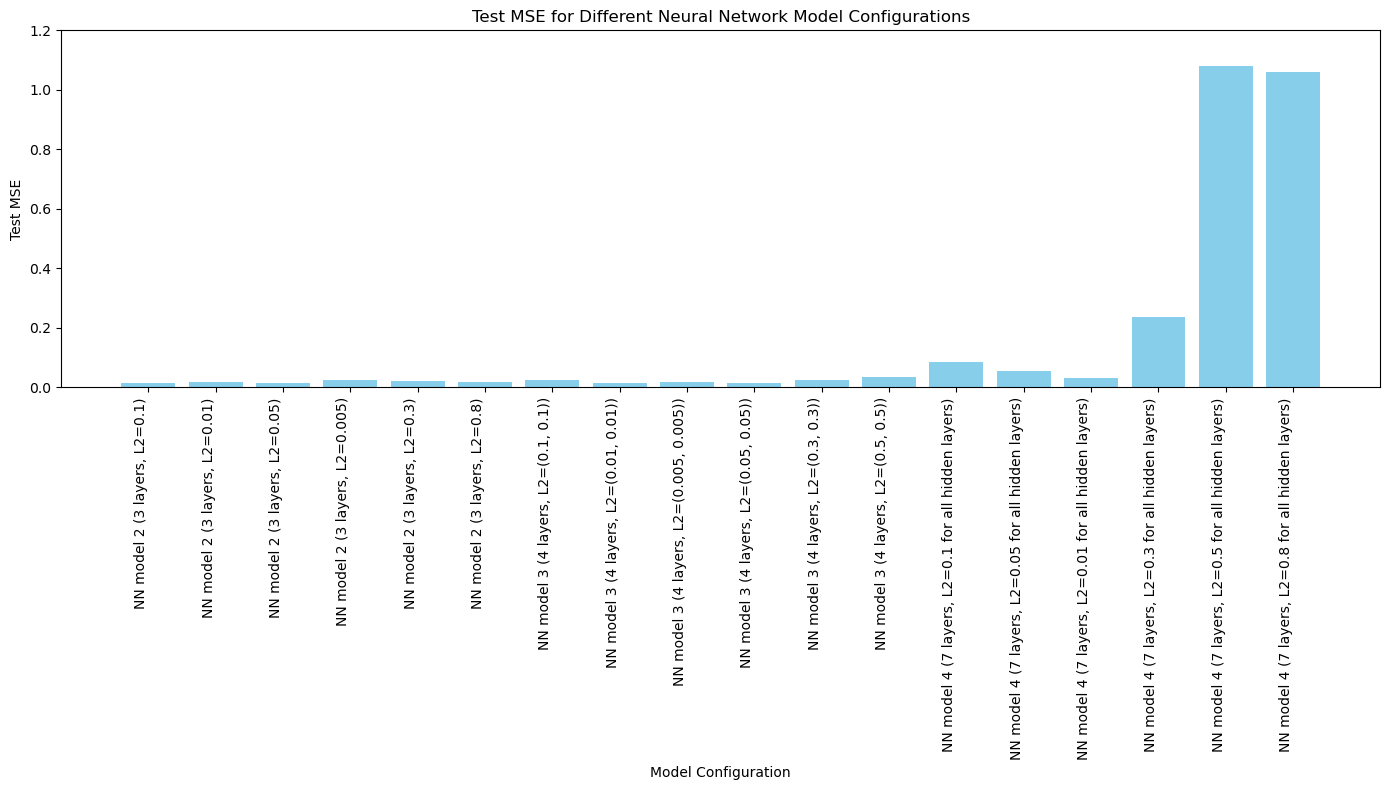

In [138]:
# Data
models = [
    "NN model 2 (3 layers, L2=0.1)",
    "NN model 2 (3 layers, L2=0.01)",
    "NN model 2 (3 layers, L2=0.05)",
    "NN model 2 (3 layers, L2=0.005)",
    "NN model 2 (3 layers, L2=0.3)",
    "NN model 2 (3 layers, L2=0.8)",
    "NN model 3 (4 layers, L2=(0.1, 0.1))",
    "NN model 3 (4 layers, L2=(0.01, 0.01))",
    "NN model 3 (4 layers, L2=(0.005, 0.005))",
    "NN model 3 (4 layers, L2=(0.05, 0.05))",
    "NN model 3 (4 layers, L2=(0.3, 0.3))",
    "NN model 3 (4 layers, L2=(0.5, 0.5))",
    "NN model 4 (7 layers, L2=0.1 for all hidden layers)",
    "NN model 4 (7 layers, L2=0.05 for all hidden layers)",
    "NN model 4 (7 layers, L2=0.01 for all hidden layers)",
    "NN model 4 (7 layers, L2=0.3 for all hidden layers)",
    "NN model 4 (7 layers, L2=0.5 for all hidden layers)",
    "NN model 4 (7 layers, L2=0.8 for all hidden layers)",
]

test_mse = [
    0.016, 0.0189, 0.0163, 0.0256, 0.0218, 0.017,
    0.0236, 0.0163, 0.0198, 0.0143, 0.0238, 0.0338,
    0.0869, 0.0543, 0.0332, 0.2371, 1.08, 1.06
]

# Plotting
plt.figure(figsize=(14, 8))
x = np.arange(len(models))  # x-axis positions
plt.bar(x, test_mse, color='skyblue')

# Customize the plot
plt.xticks(x, models, rotation=90, ha='right')
plt.xlabel('Model Configuration')
plt.ylabel('Test MSE')
plt.title('Test MSE for Different Neural Network Model Configurations')
plt.ylim(0, 1.2)  # Set y-axis limit for better visualization
plt.tight_layout()

# Show the plot
plt.show()
